In [1]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilities.plotlib as pltlib 
import itertools
from scipy import interp
from sklearn.metrics import roc_curve, auc

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
DIR = "C:\\Users\\user\\Documents\\Fifth Year\\Report\\"

results = ['ggF125', 'VBF125', 'WH125', 'ZH125', 'ttH125']
network_results = []
labels = []

RESULTS_DIR = results[4]
signal = RESULTS_DIR.partition('1')[0]
background = 'Background'

df_nn = pd.read_pickle('{0}\\results_FFN_{0}.pkl'.format(RESULTS_DIR))
df_nn = df_nn[df_nn.loc[:, 'test_passed'] == True]

if df_nn.empty:
    pass
else:
    network_results += [df_nn]
    labels += ['FFN']
    
df_rnn = pd.read_pickle('{0}\\results_RNN_{0}.pkl'.format(RESULTS_DIR))
df_rnn = df_rnn[df_rnn.loc[:, 'test_passed'] == True]

if df_rnn.empty:
    pass
else:
    network_results += [df_rnn]
    labels += ['RNN']

df_combined = pd.read_pickle('{0}\\results_combined_{0}.pkl'.format(RESULTS_DIR))
df_combined = df_combined[df_combined.loc[:, 'test_passed'] == True]

if df_combined.empty:
    pass
else:
    network_results += [df_combined]
    labels += ['FFN + RNN']

for df in network_results:
    df.history_training_data = df.history_training_data.apply(lambda x:np.array(x))
    df.history_test_data = df.history_test_data.apply(lambda x:np.array(x))

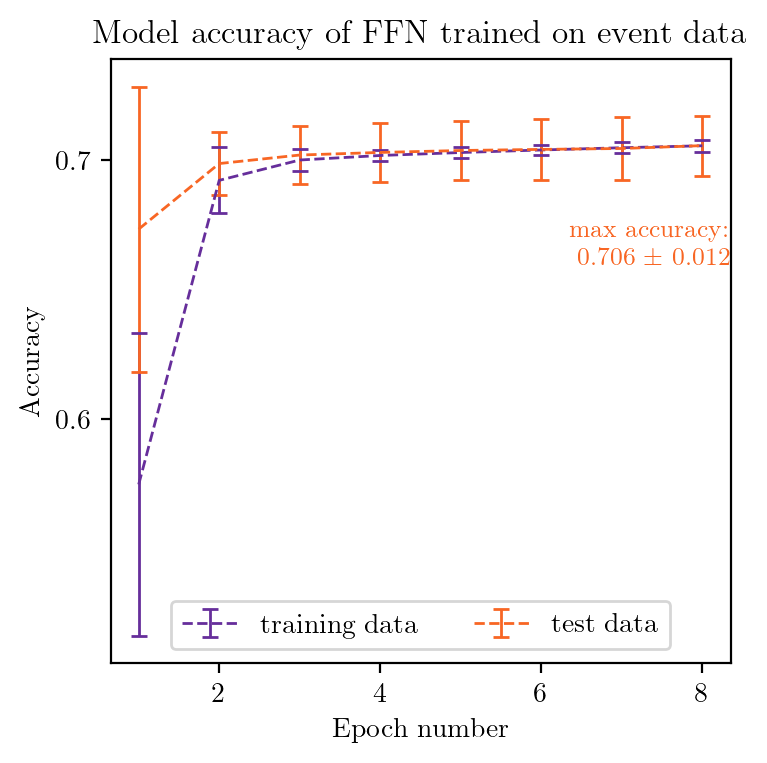

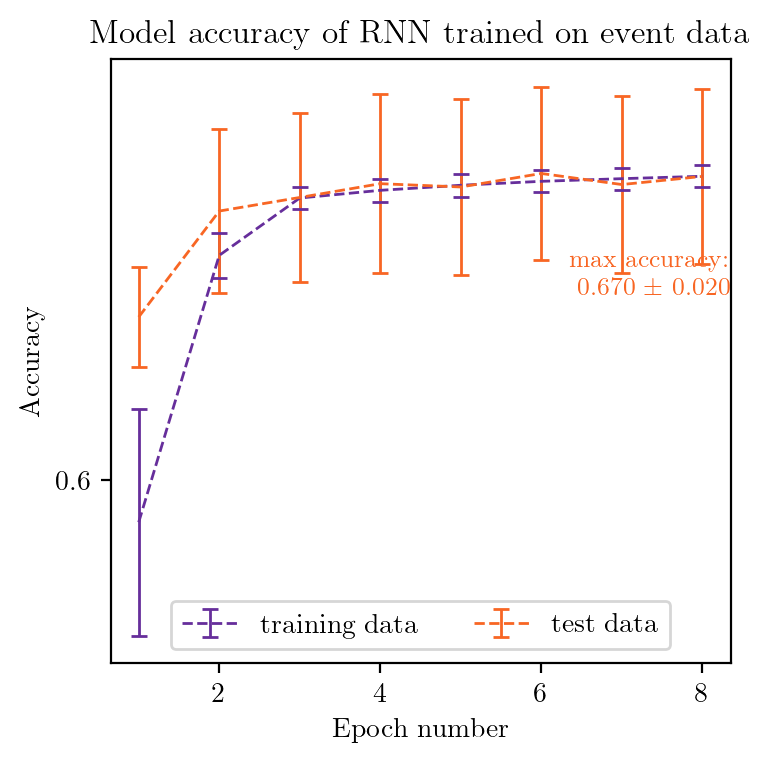

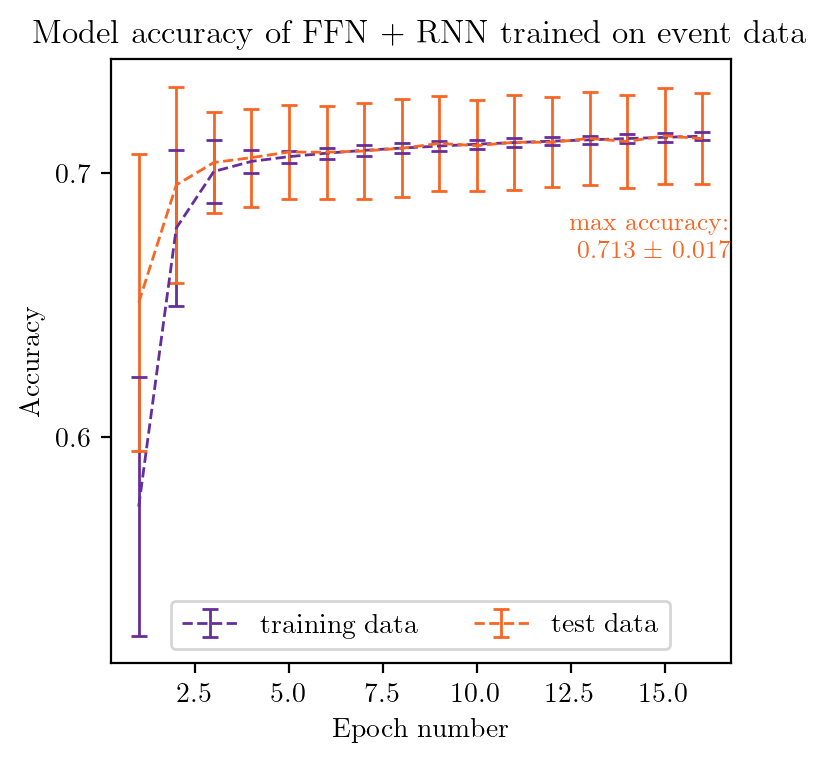

In [3]:
for name, df in zip(labels, network_results):
    params_history = {'title' : ('Model accuracy of {} trained on event data'.format(name)),
                'x_axis' : 'Epoch number',
                'y_axis' : 'Accuracy',
                'legend' : ['training data', 'test data'],
                'figsize' : (4, 4),
                'dpi' : 200,
                'colors' : ['#662E9B', '#F86624'],
                'full_y' : False}
    
    history_training_data_mean = np.mean(df.history_training_data, axis=0)
    history_test_data_mean = np.mean(df.history_test_data, axis=0)
    
    history_training_data_std = np.std(df.history_training_data.values, axis=0)
    history_test_data_std = np.std(df.history_test_data.values, axis=0)
    
    history_error_bars = [history_training_data_std, history_test_data_std]
    
    fig1 = pltlib.training_history_plot(history_training_data_mean,
                              history_test_data_mean,
                              params_history,
                              history_error_bars)
    
#     fig1.savefig(DIR + 'training_history_{}.pdf'.format(name))

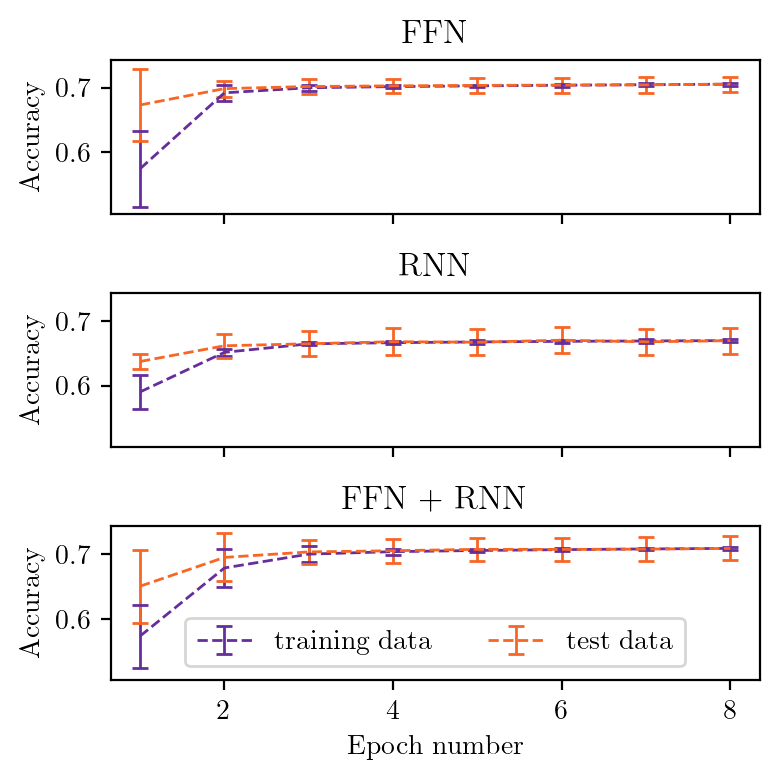

In [4]:
if len(labels) == 1:
    pass
else:
    fig, axes = plt.subplots(nrows=len(labels), figsize=(4,4), dpi=200, sharex=True, sharey=True)
    epochs = np.arange(8)+1

    for name, df, ax in zip(labels, network_results, axes):
        params = {'title' : ('Model accuracy of {} trained on event data'.format(name)),
                    'x_axis' : 'Epoch number',
                    'y_axis' : 'Accuracy',
                    'legend' : ['training data', 'test data'],
                    'figsize' : (4, 4),
                    'dpi' : 200,
                    'colors' : ['#662E9B', '#F86624'],
                    'full_y' : False}

        history_training_data_mean = np.mean(df.history_training_data, axis=0)[:8]
        history_test_data_mean = np.mean(df.history_test_data, axis=0)[:8]

        history_training_data_std = np.std(df.history_training_data.values, axis=0)[:8]
        history_test_data_std = np.std(df.history_test_data.values, axis=0)[:8]

        history_error_bars = [history_training_data_std, history_test_data_std]

        ax.errorbar(epochs, history_training_data_mean, 
                     yerr=history_error_bars[0], 
                     capsize=3, lw=1, ls='--' , 
                     color=params['colors'][0])

        ax.errorbar(epochs, history_test_data_mean, 
                     yerr=history_error_bars[1], 
                     capsize=3, lw=1, ls='--' ,
                     color=params['colors'][1])

    #     ax.annotate(f'max accuracy:\n{history_test_data_mean[-1]:0.2f} \u00B1 {history_error_bars[1][-1]:0.2f}', 
    #                 (epochs[-1], history_test_data_mean[-1]), 
    #                 xytext=(10, -25), textcoords='offset points',
    #                 ha='right', va='center', 
    #                 fontsize=9, color=params['colors'][1])

        ax.set_title(name)
        ax.set_ylabel('Accuracy')

    ax.set_xlabel(params['x_axis'])
    plt.legend(params['legend'], loc='lower center', ncol=2)
    fig.tight_layout()
    # fig.savefig(DIR + 'training_history.pdf')

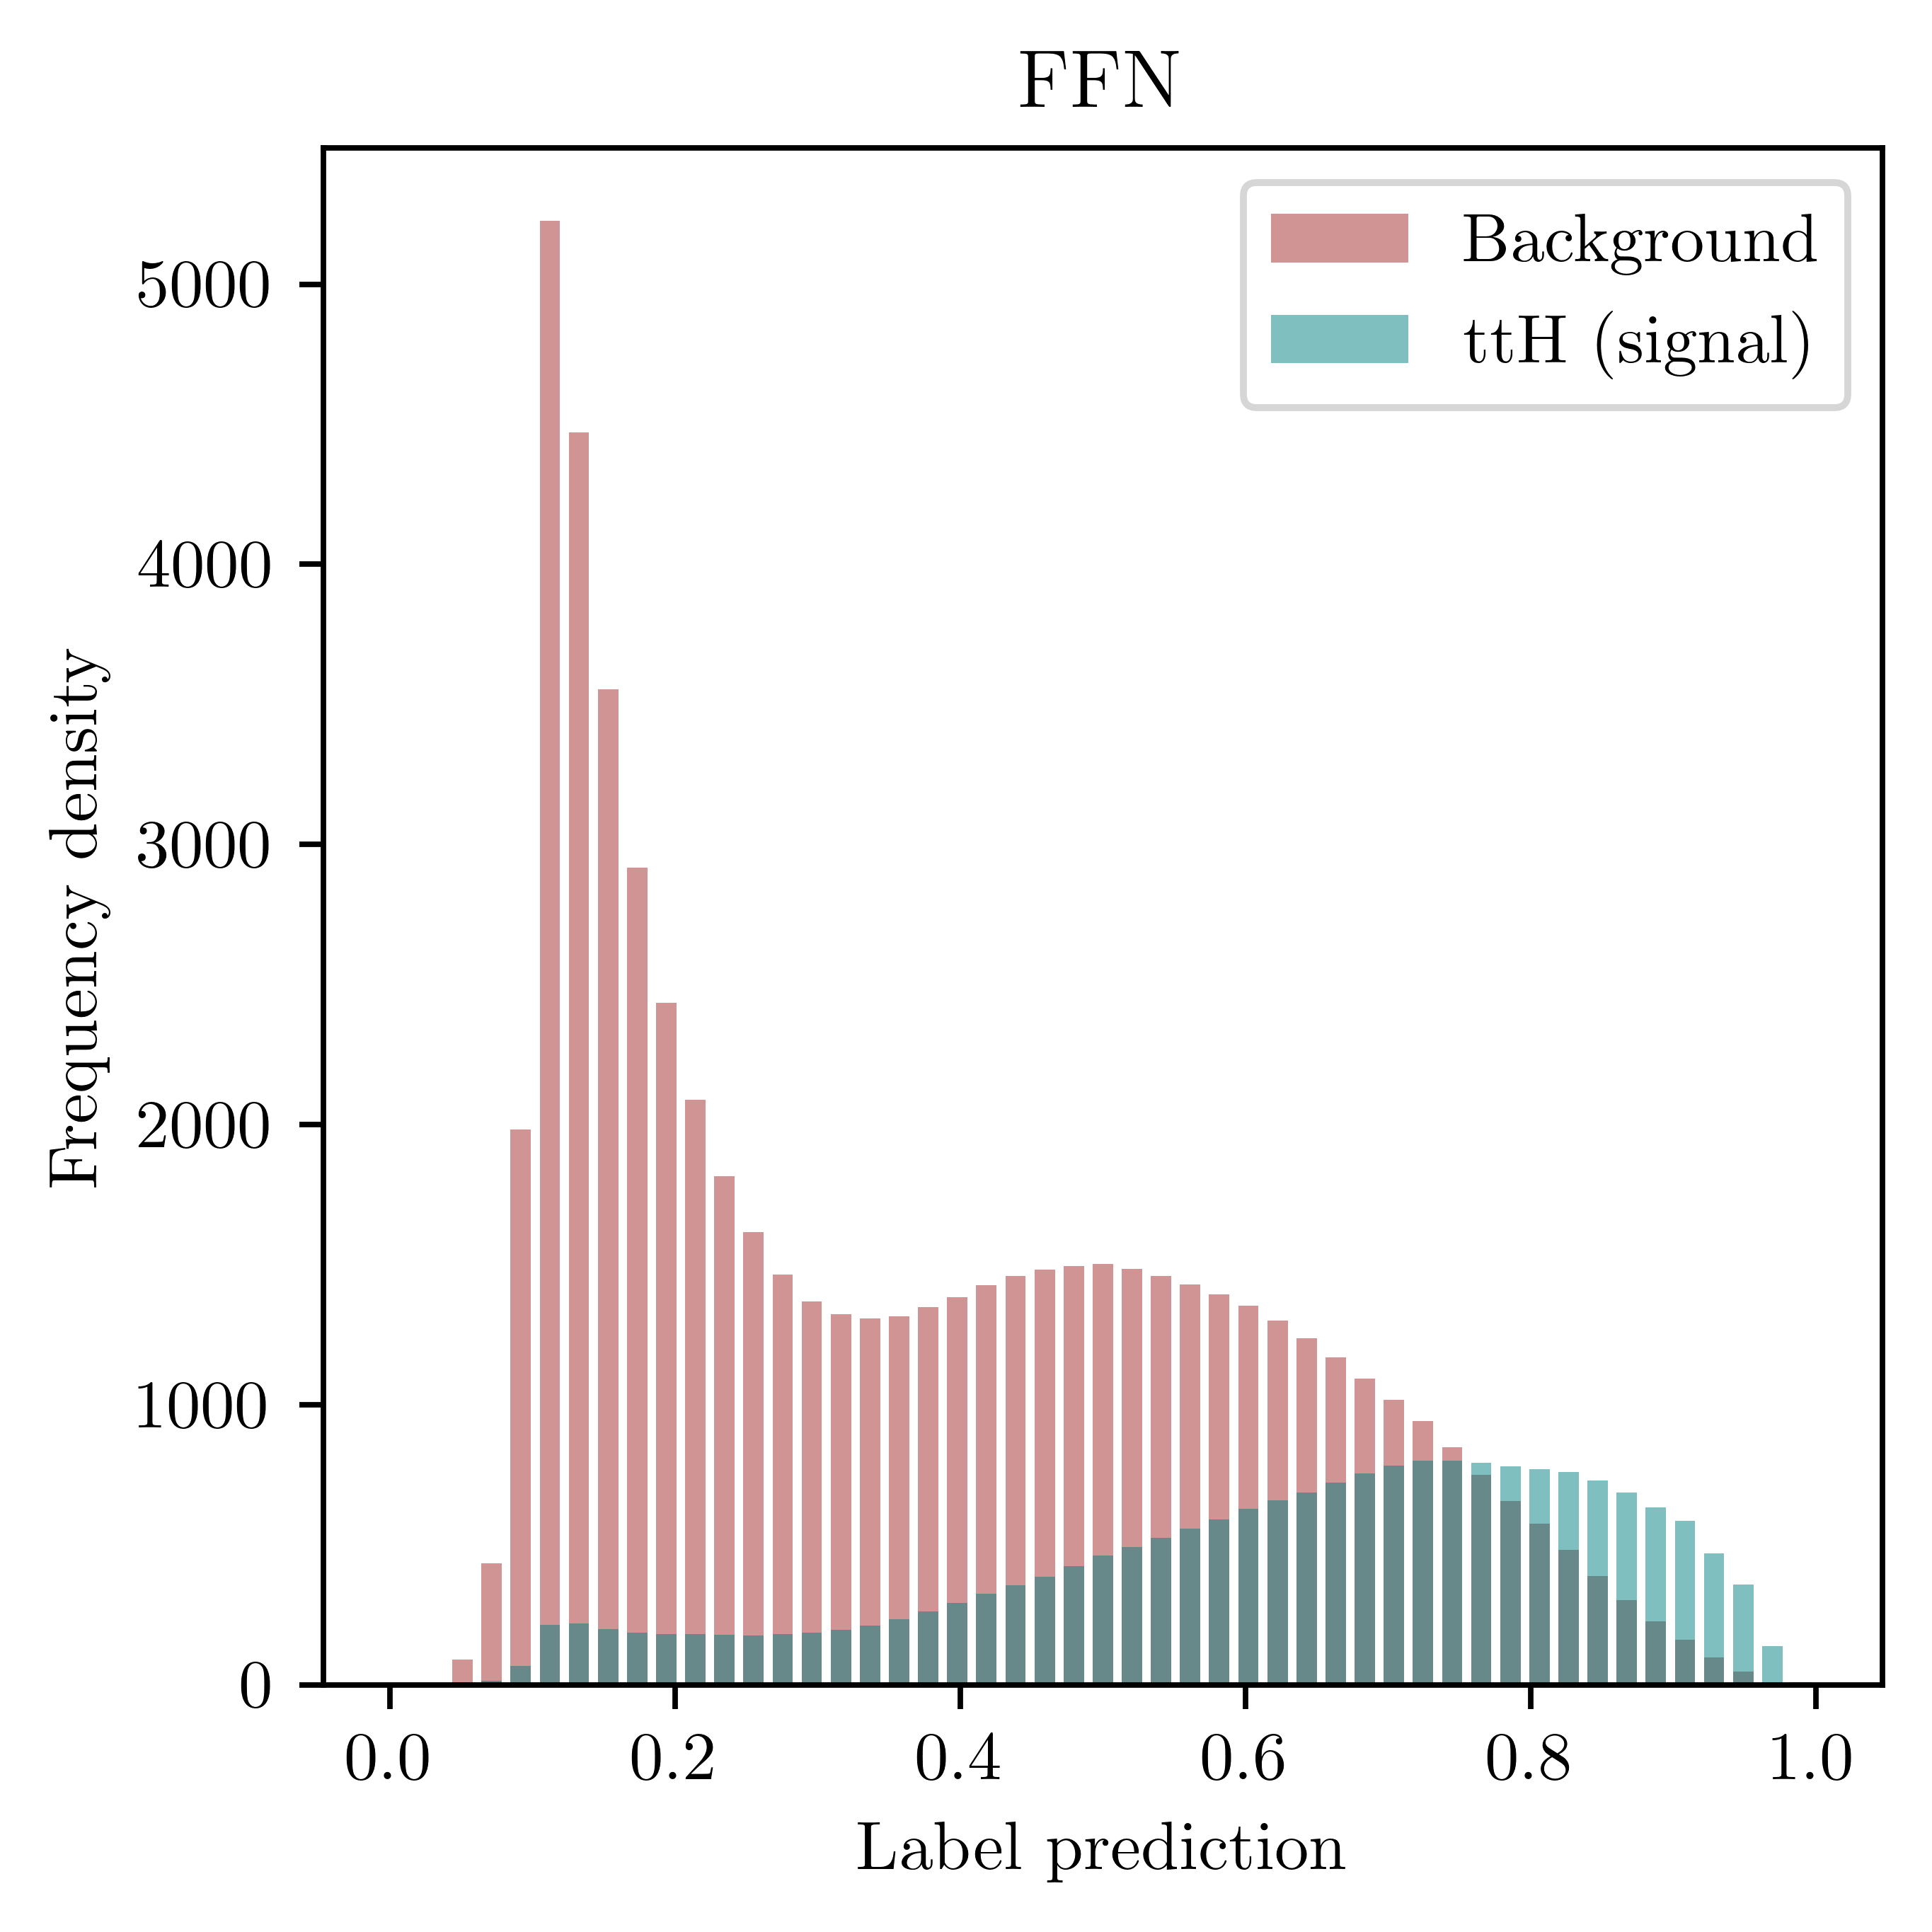

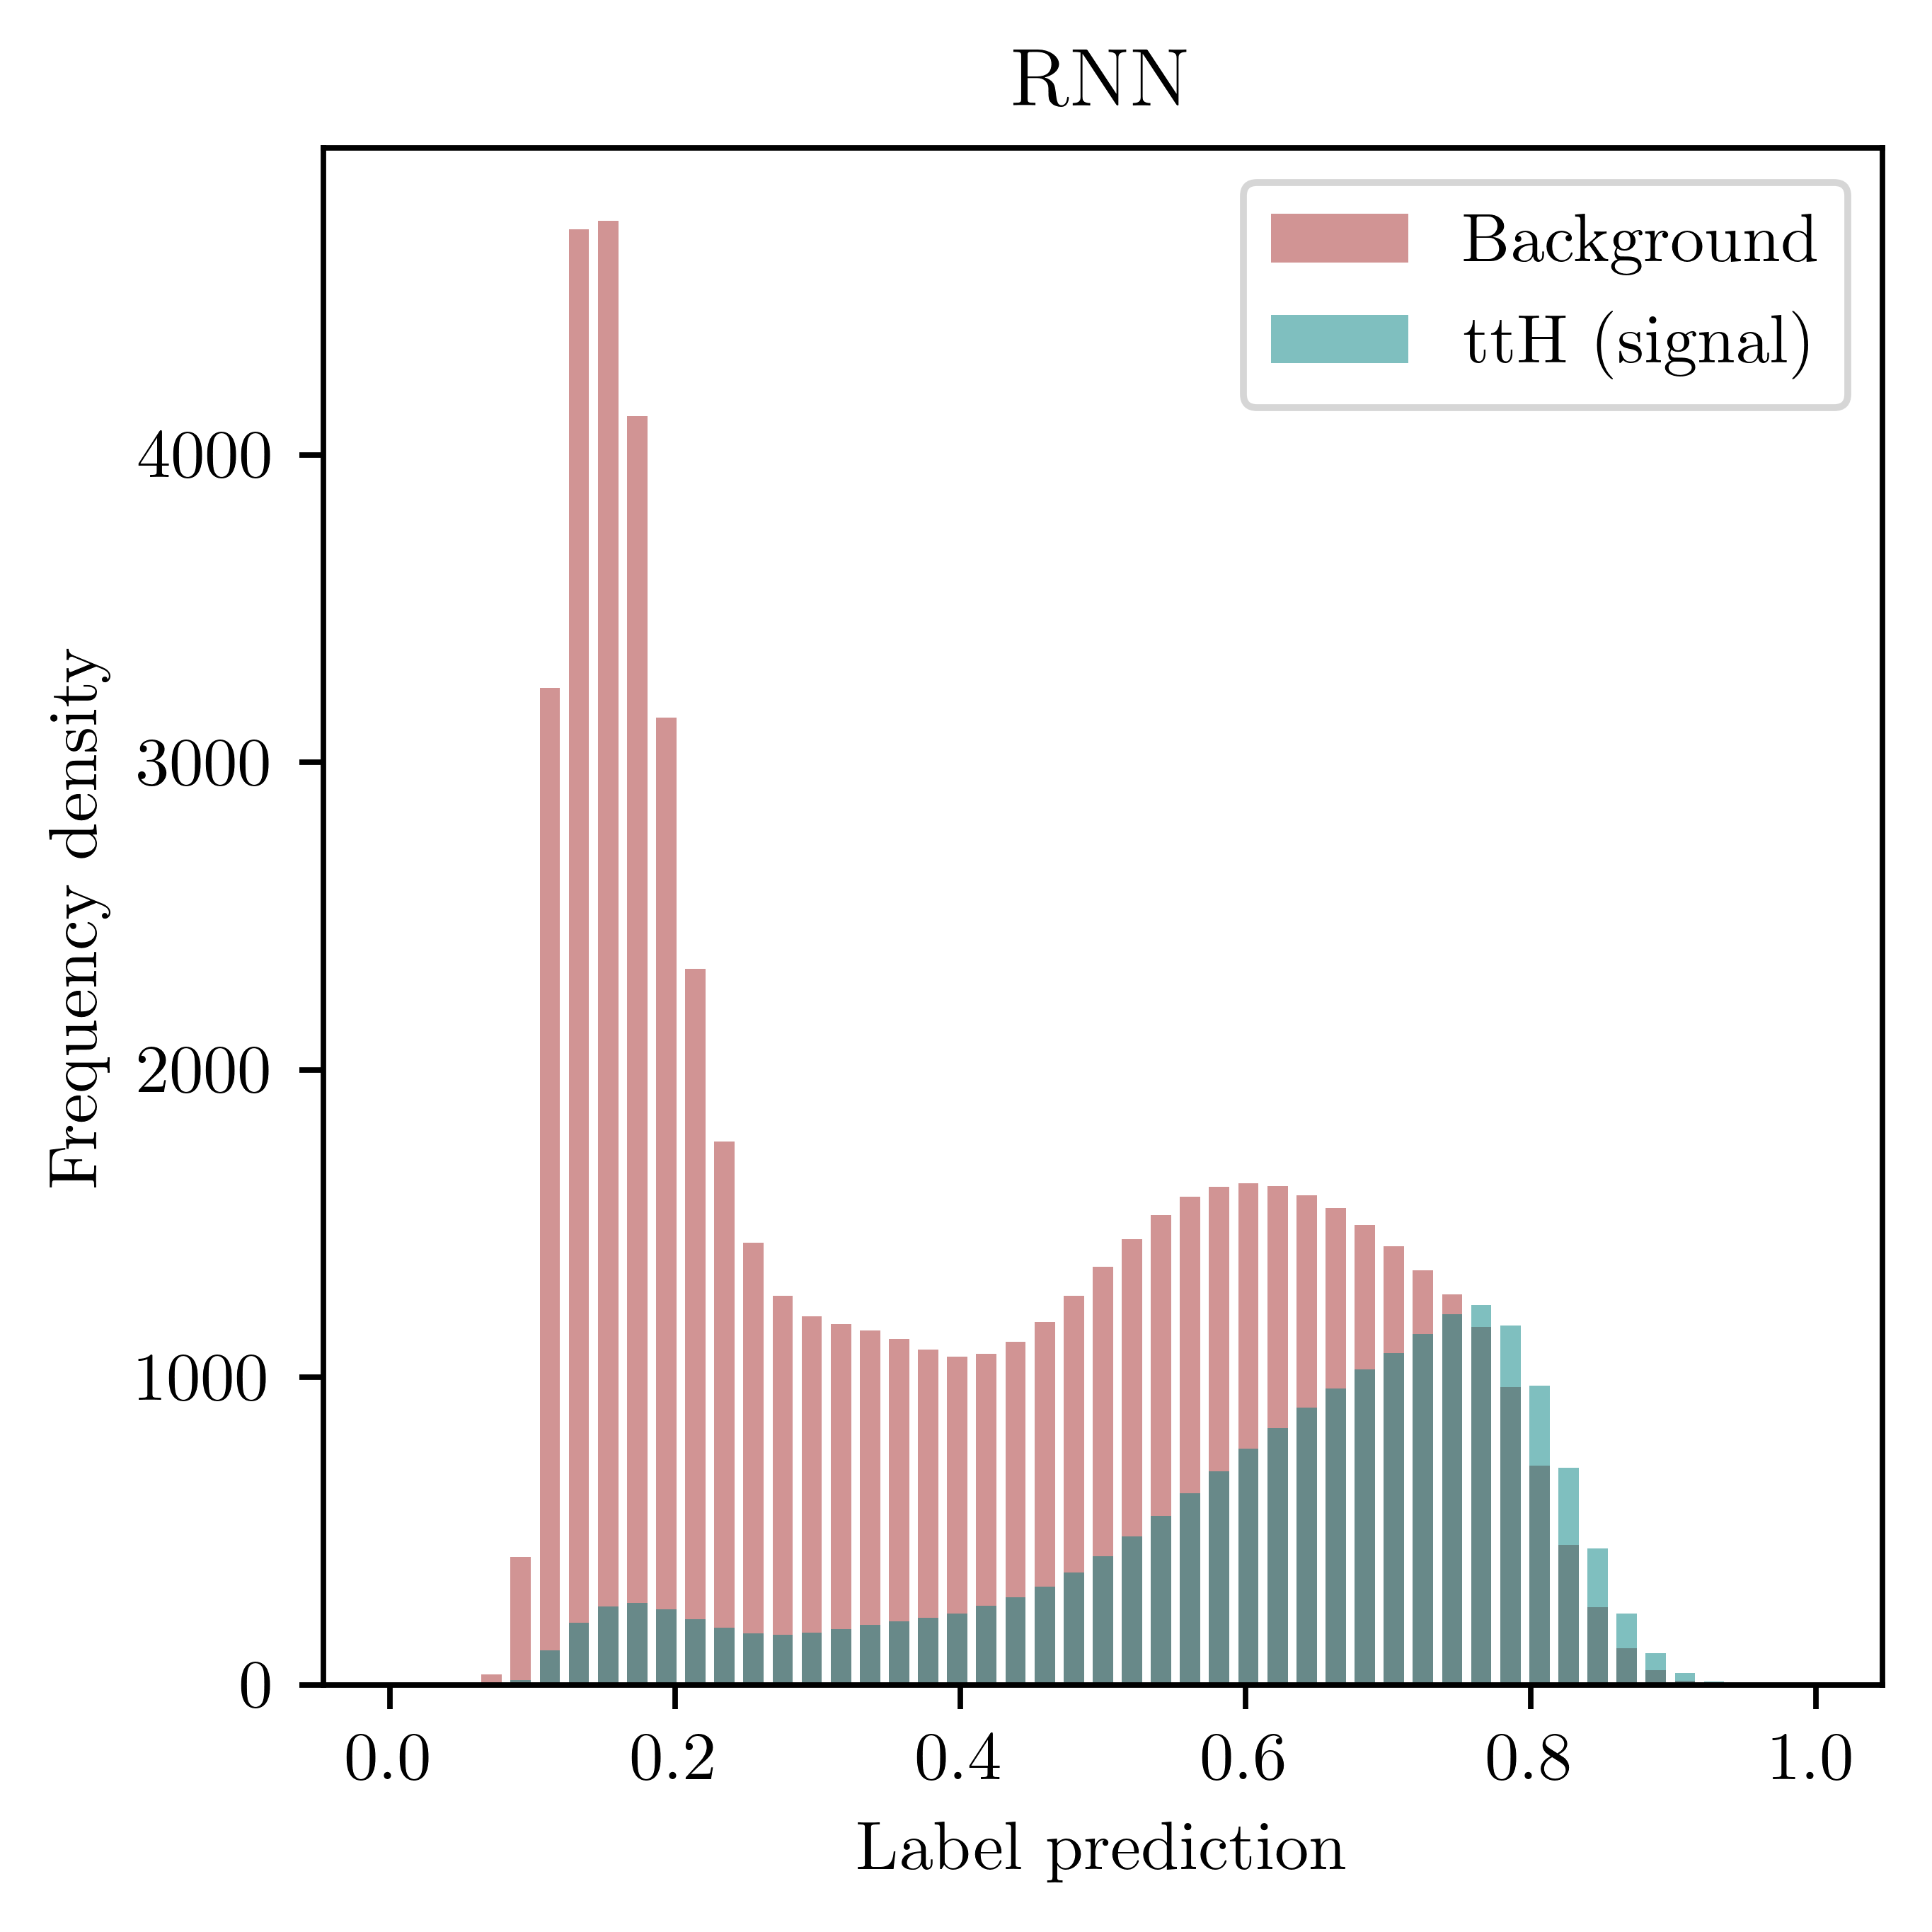

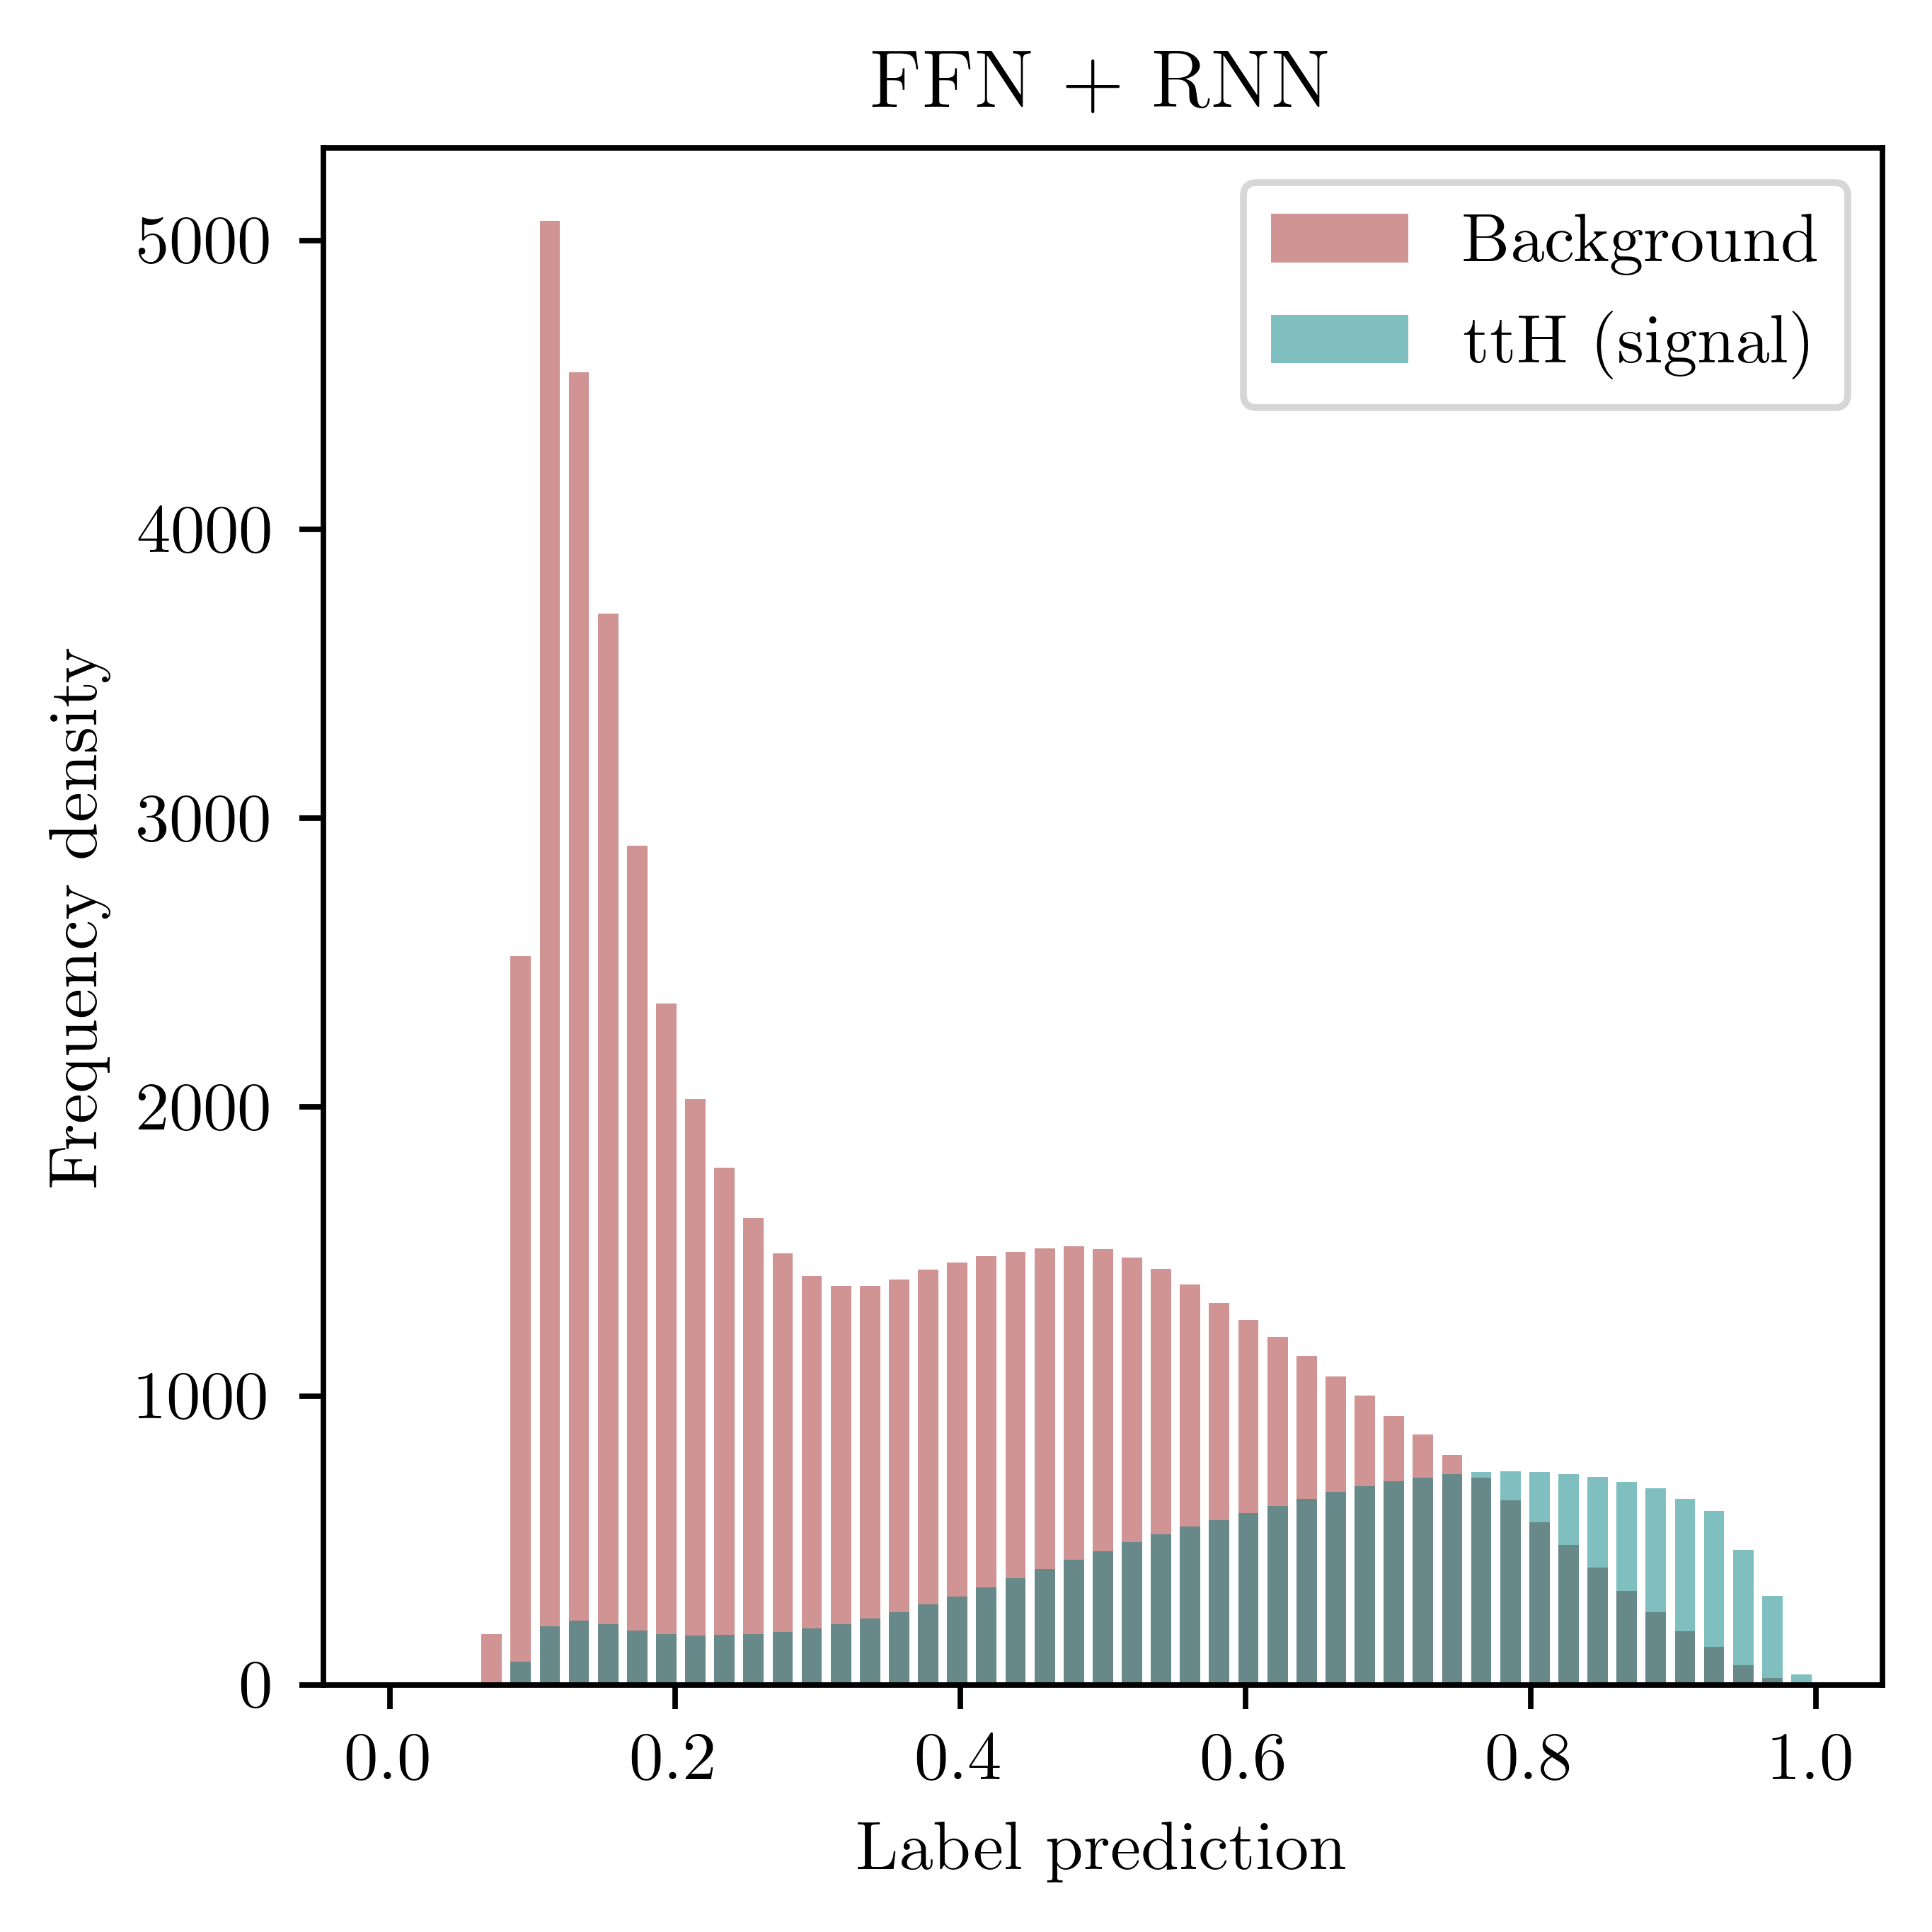

In [5]:
for name, df in zip(labels, network_results):
    fig2, ax2 = plt.subplots(figsize=(4,4), dpi=700)
    background_bin_vals = np.mean(df.background_bin_vals, axis=0)
    signal_bin_vals = np.mean(df.signal_bin_vals, axis=0)
    background_bin_err = np.std(df.background_bin_vals.values, axis=0)
    signal_bin_err = np.std(df.signal_bin_vals.values, axis=0)

    bin_edges = df.bins.iloc[0]
    bin_width = 0.7 * (bin_edges[1] - bin_edges[0])
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    colours = ['brown', 'teal']
    
    ax2.bar(bin_centers, background_bin_vals, align='center', width=bin_width, alpha=0.5,
           label='{}'.format(background), color=colours[0])
    ax2.bar(bin_centers, signal_bin_vals, align='center', width=bin_width, alpha=0.5,
           label='{} (signal)'.format(signal), color=colours[1])
    ax2.set_xlabel('Label prediction')
    ax2.set_ylabel('Frequency density')
    ax2.set_title(name)
    ax2.legend()
    fig2.tight_layout()
#     fig2.savefig(DIR + '{}_discriminator_plot.pdf'.format(name))
    

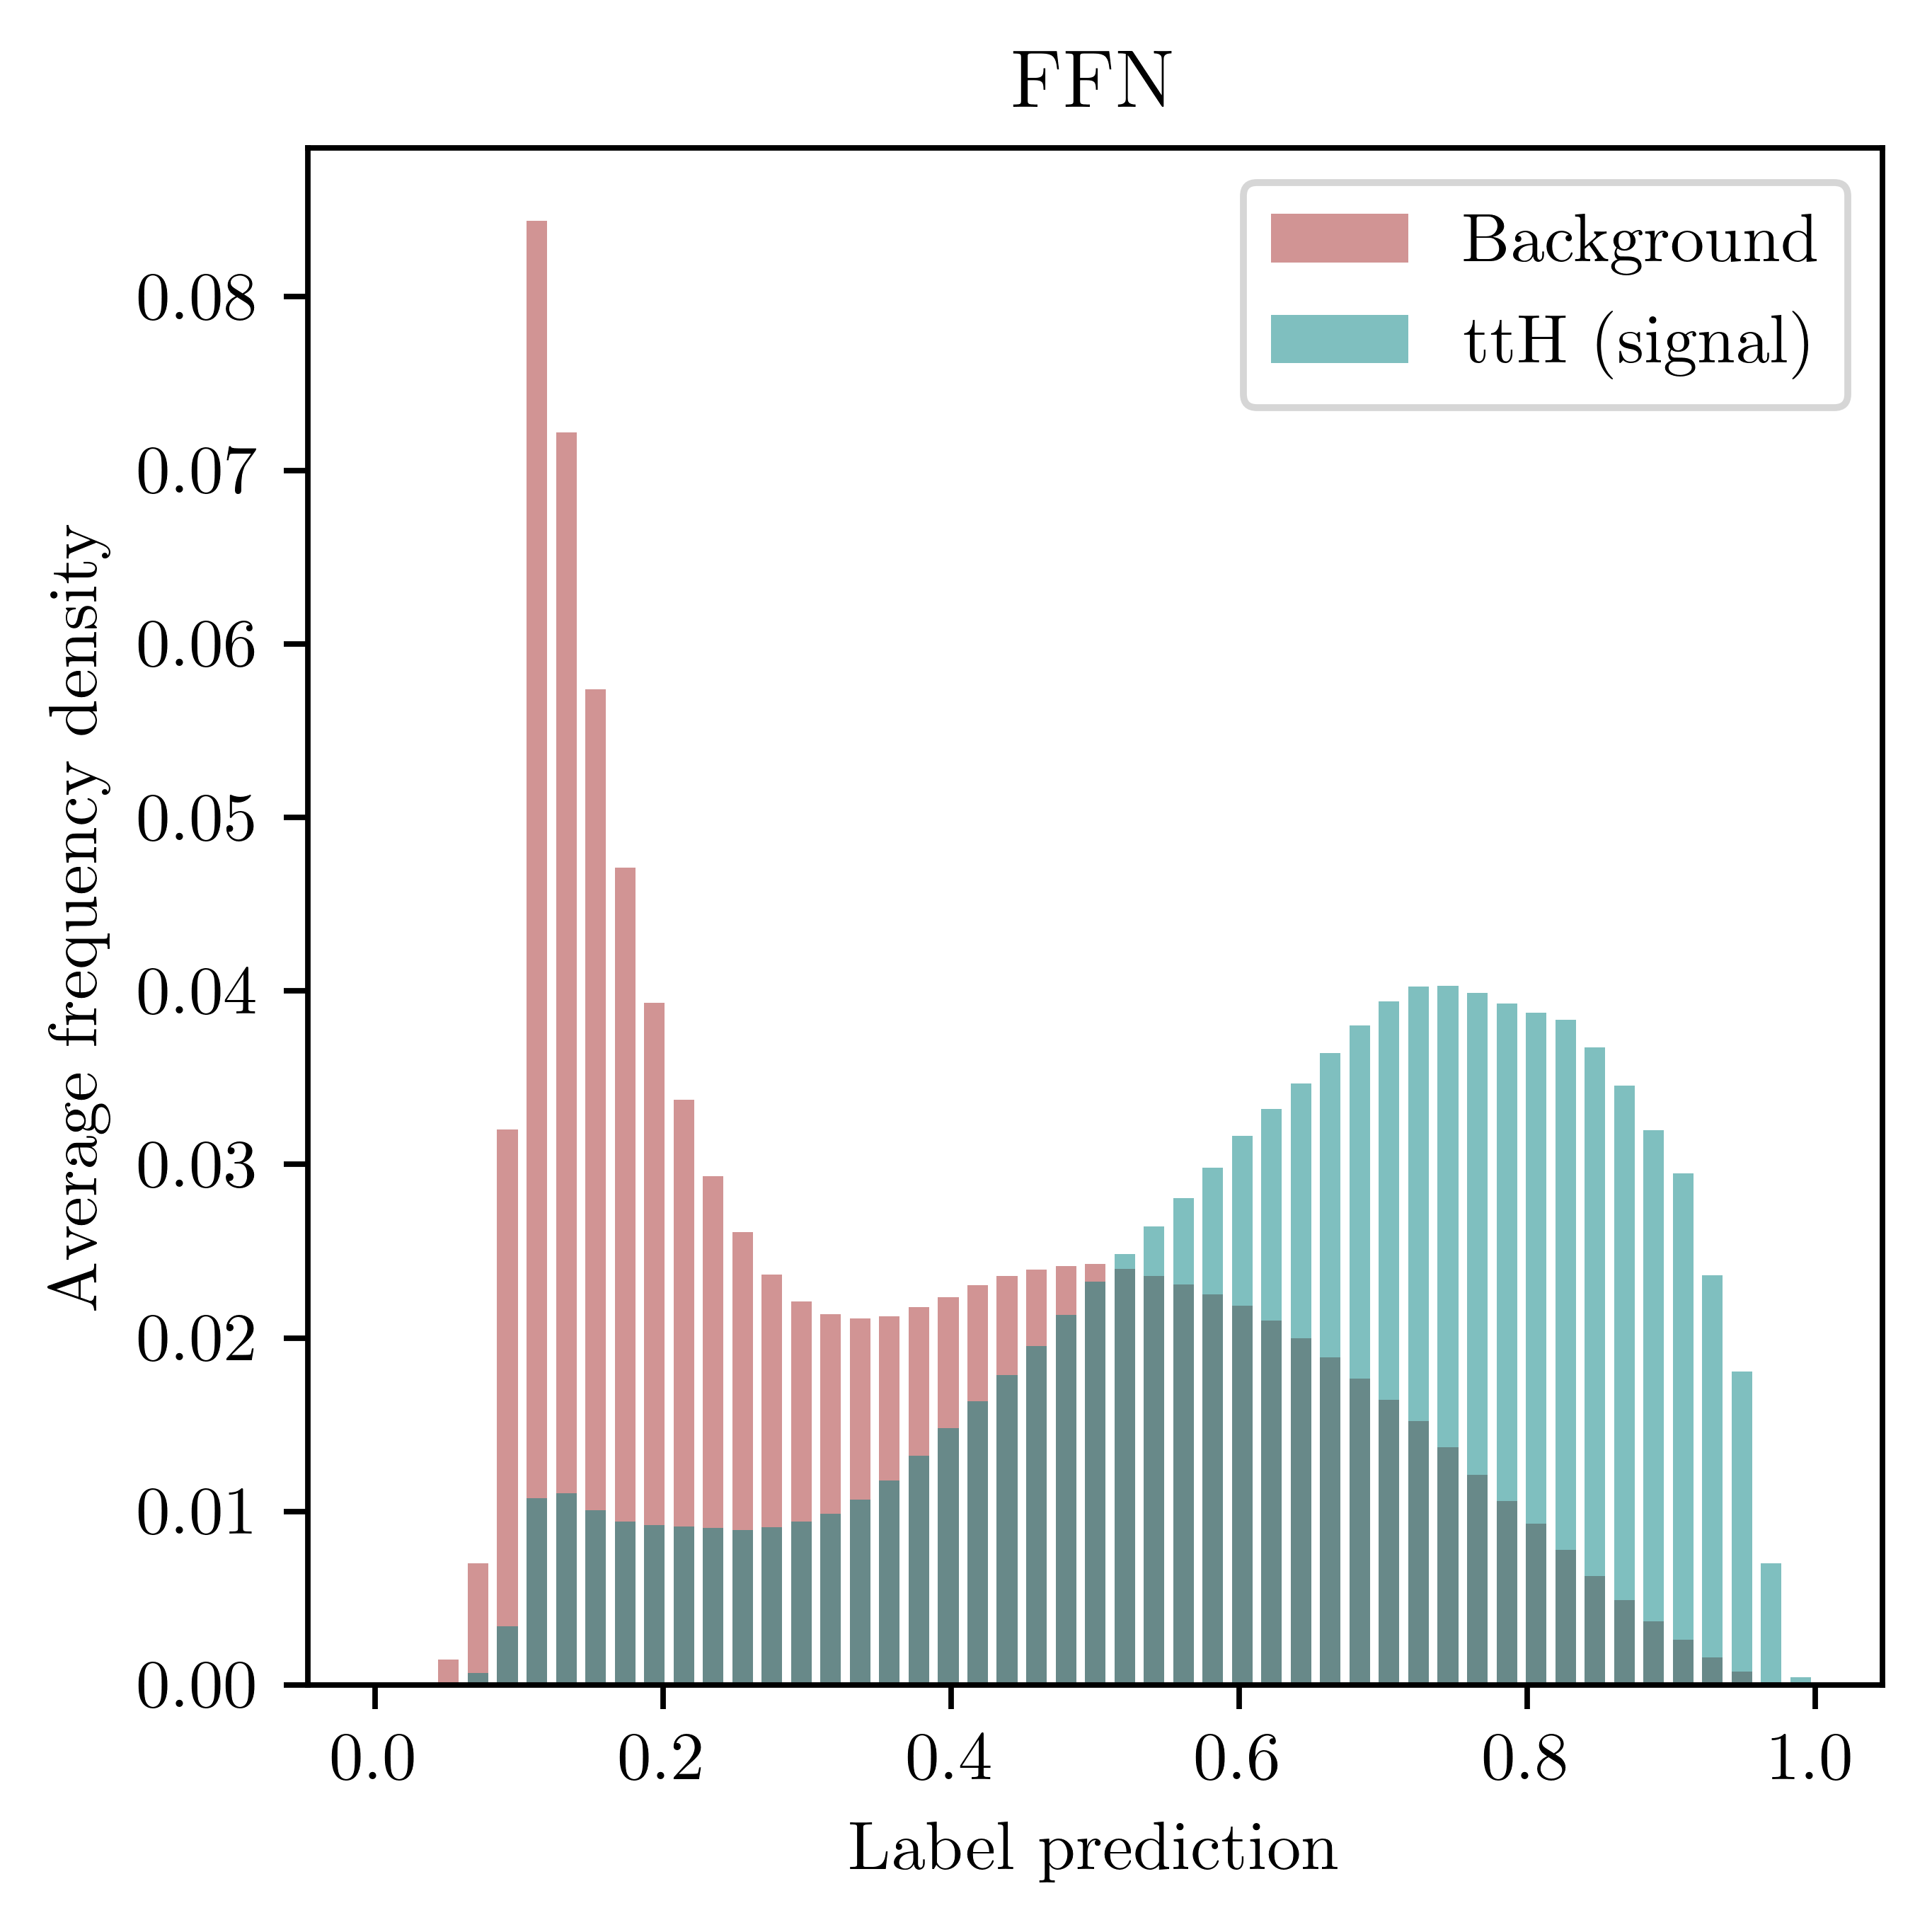

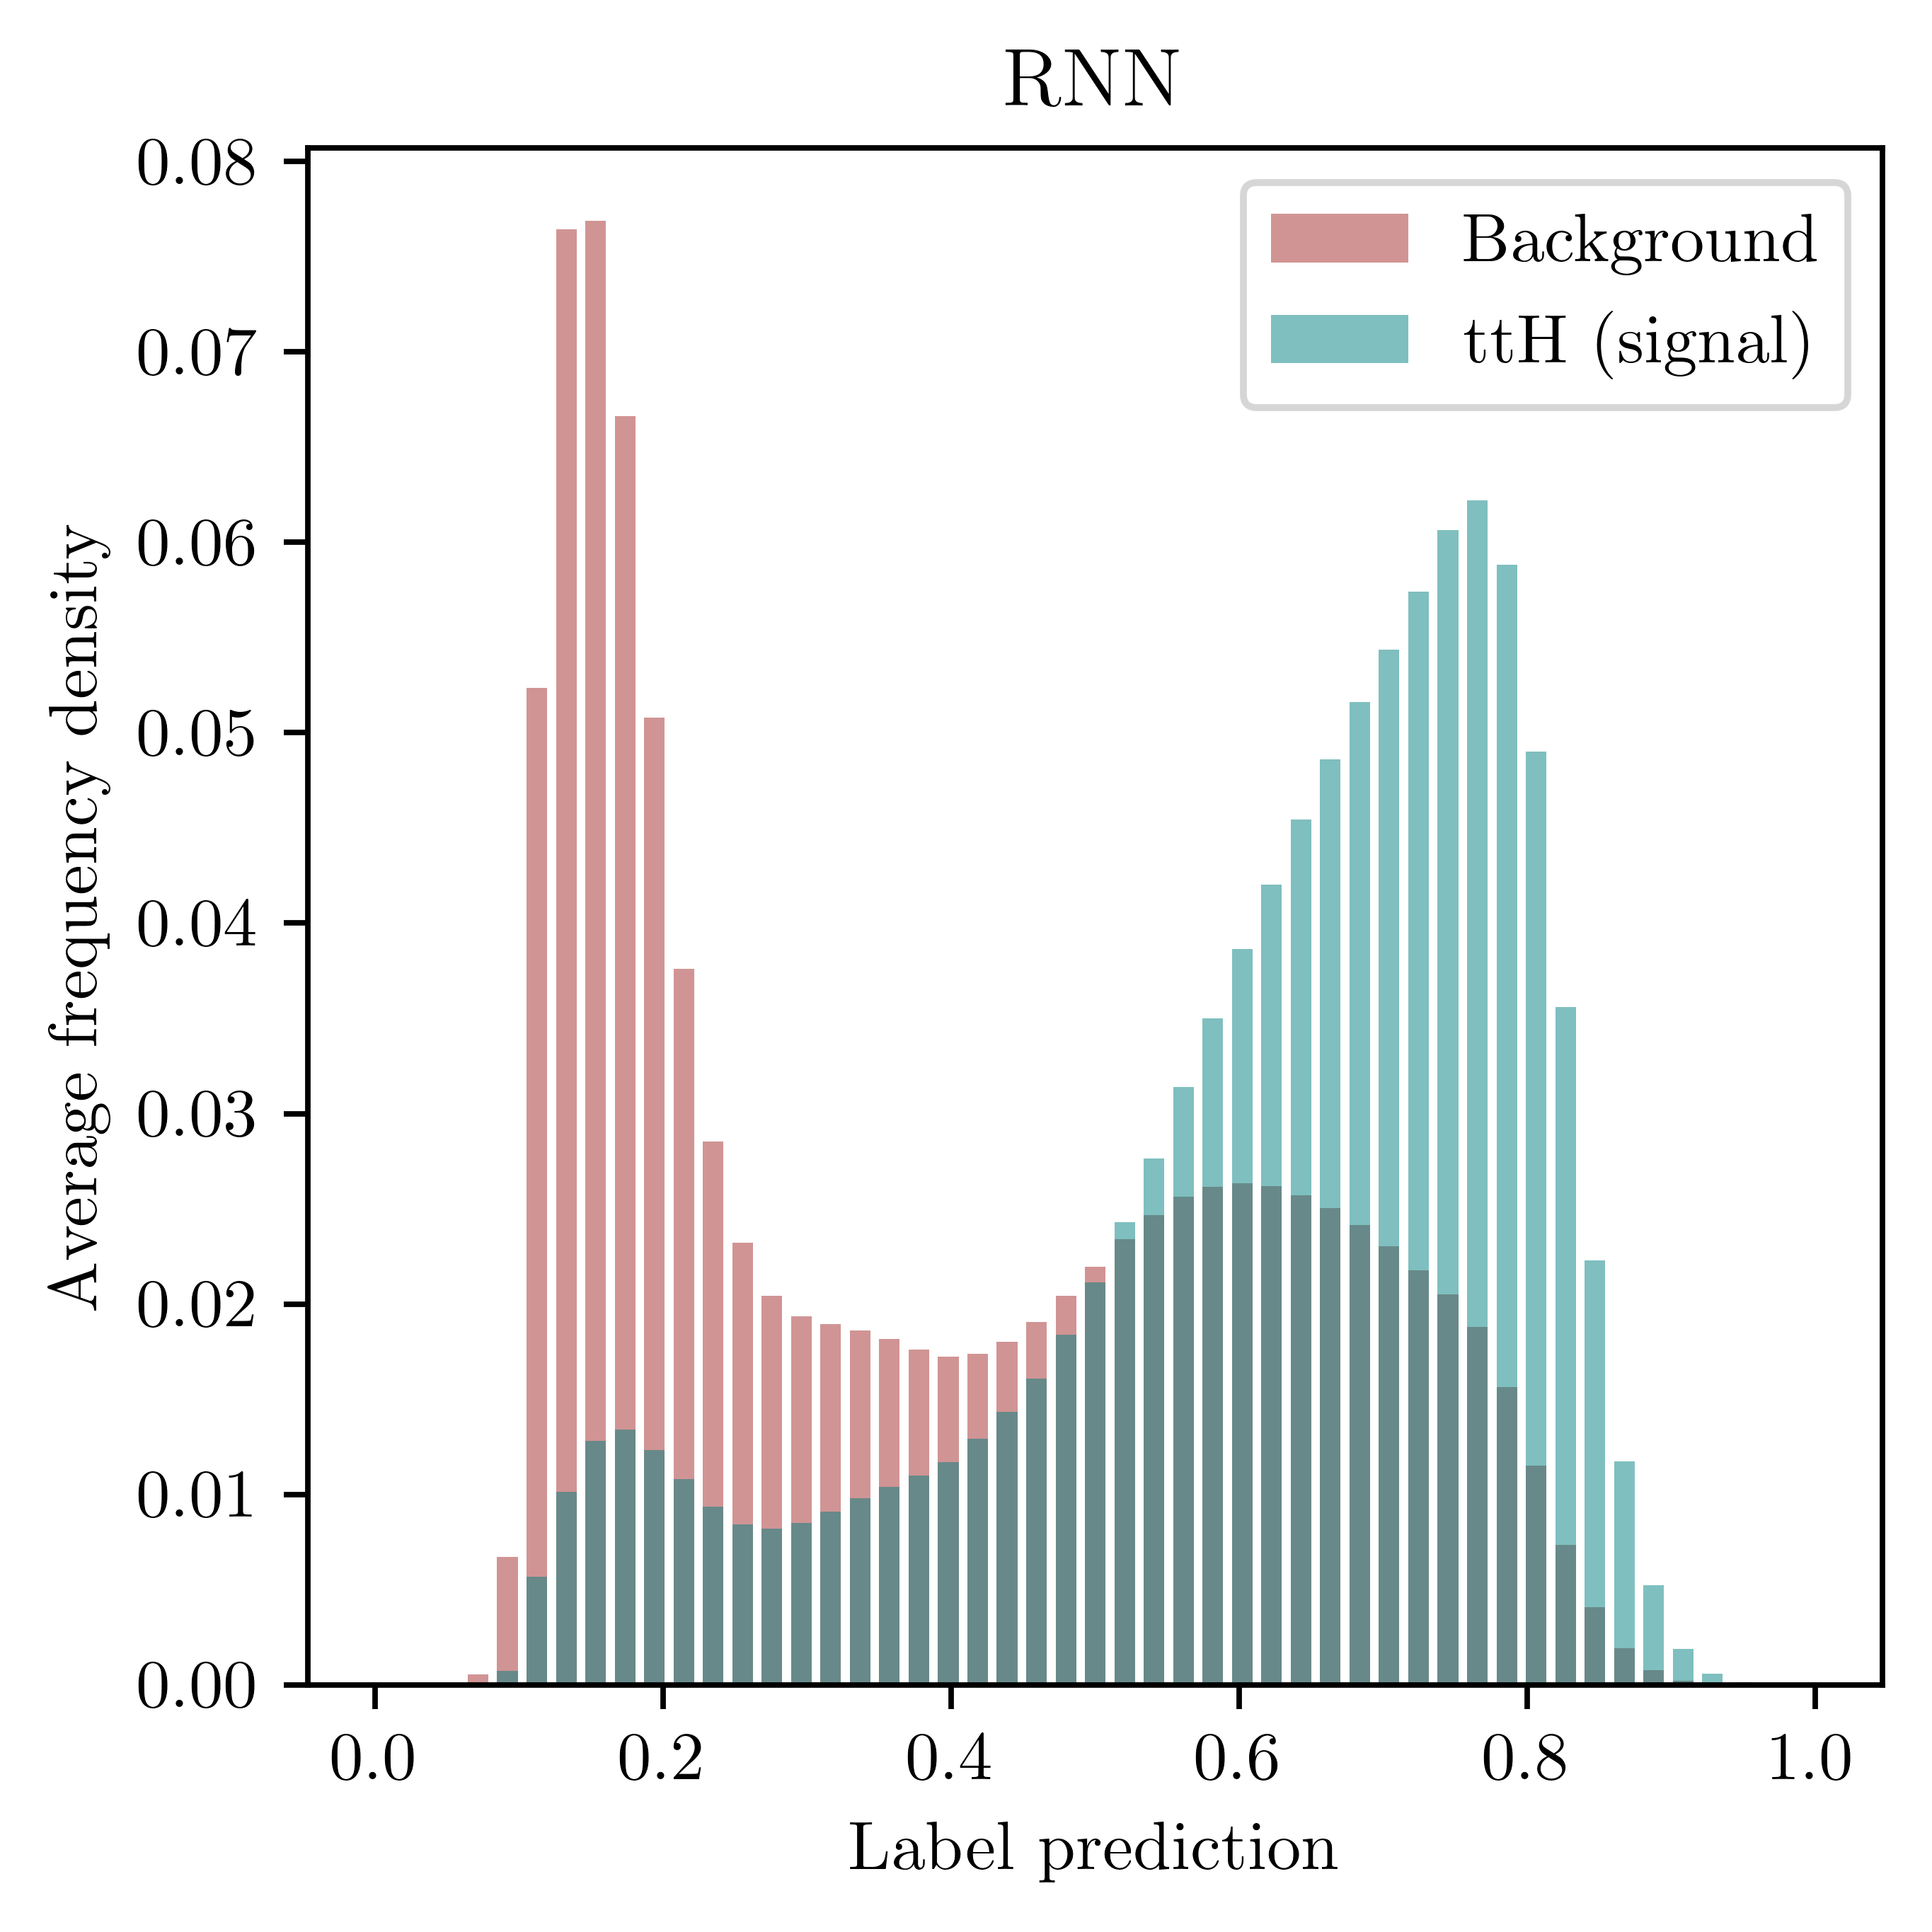

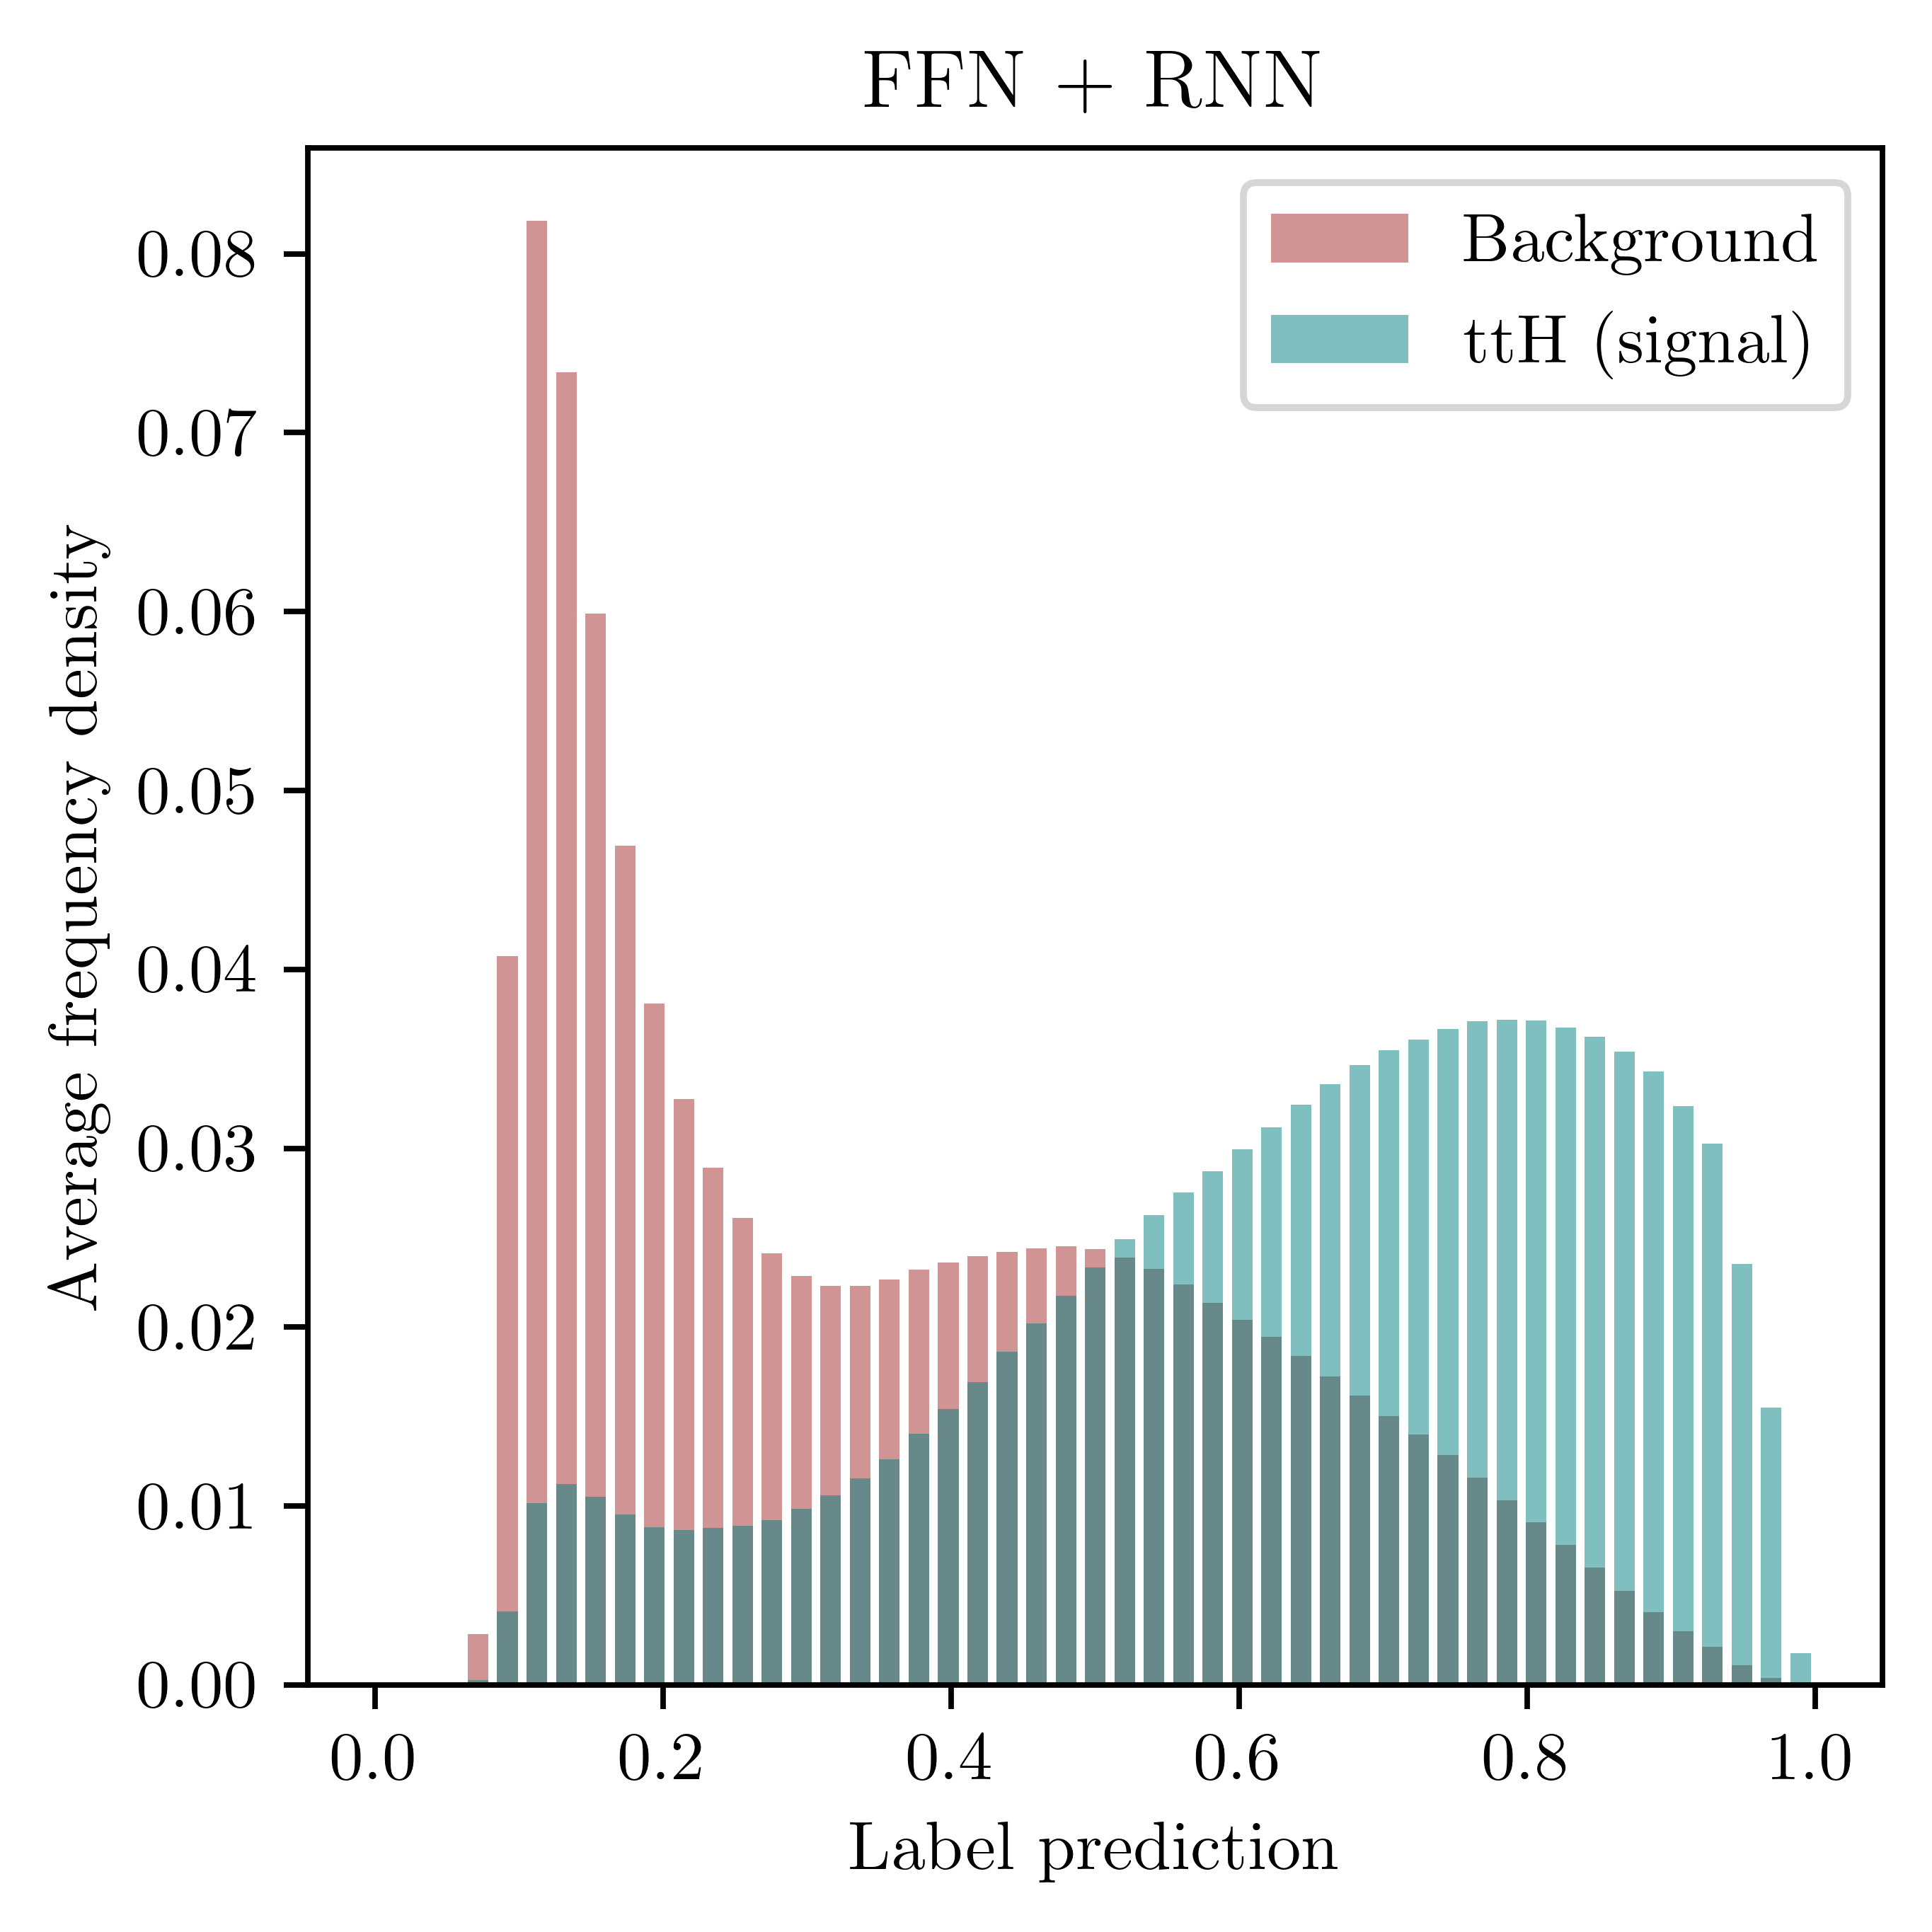

In [6]:
for name, df in zip(labels, network_results):
    fig2_norm, ax2_norm = plt.subplots(figsize=(4,4), dpi=700)
    background_bin_vals = np.mean(df.background_bin_vals, axis=0)
    signal_bin_vals = np.mean(df.signal_bin_vals, axis=0)
    
    bin_edges = df.bins.iloc[0]
    bin_width = 0.7 * (bin_edges[1] - bin_edges[0])
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    width = bin_edges[1] - bin_edges[0]
    background_area = sum(background_bin_vals)
    signal_area = sum(signal_bin_vals)
    
    background_bin_vals = background_bin_vals / background_area
    signal_bin_vals = signal_bin_vals / signal_area
    
    colours = ['brown', 'teal']
    
    ax2_norm.bar(bin_centers, background_bin_vals, align='center', width=bin_width, alpha=0.5,
           label='{}'.format(background), color=colours[0])
    ax2_norm.bar(bin_centers, signal_bin_vals, align='center', width=bin_width, alpha=0.5,
           label='{} (signal)'.format(signal), color=colours[1])
    
    ax2_norm.set_xlabel('Label prediction')
    ax2_norm.set_ylabel('Average frequency density')
    ax2_norm.set_title(name)
    ax2_norm.legend()
    fig2_norm.tight_layout()
    #fig2_norm.savefig(DIR + '{0}\\discriminator_plot_{1}_{0}.pdf'.format(RESULTS_DIR,name))

In [7]:
all_data = df['confusion_matrix'].dropna().values
all_data = np.concatenate(all_data, axis=0)
all_data = all_data.reshape([-1, 2, 2])
data_mean = np.mean(all_data, axis=0)
print(data_mean[0].sum())
print(data_mean[1].sum())

61922.162650602404
19872.83734939759


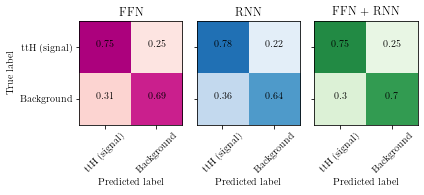

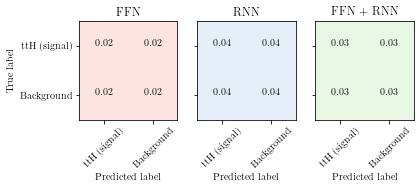

In [8]:

class_names =  ['{} (signal)'.format(signal), '{}'.format(background)]
cm_list = []
cm_err = []

for df in network_results:
    all_data = df['confusion_matrix'].dropna().values
    all_data = np.concatenate(all_data, axis=0)
    all_data = all_data.reshape([-1, 2, 2])
    data_mean = np.mean(all_data, axis=0)
    data_std = np.std(all_data, axis=0)
    
    data_std = np.around(data_std.astype('float') / data_mean.sum(axis=1)[:, np.newaxis], decimals=2)
    
    data_mean = np.rot90(data_mean, 2)
    
    cm_list += [data_mean]
    cm_err += [data_std]

if len(labels) == 1:
    pass
else:
    fig3 = pltlib.mulit_confusion_matrix(cm_list, class_names, labels, figsize=(4, 4), dpi=200)
    fig3.tight_layout()
    #fig3.savefig(DIR + '{0}\\confusion_matrices_{0}.pdf'.format(RESULTS_DIR))

    fig3_err = pltlib.mulit_confusion_matrix(cm_err, class_names, labels, figsize=(4, 4), dpi=200, norm=False)


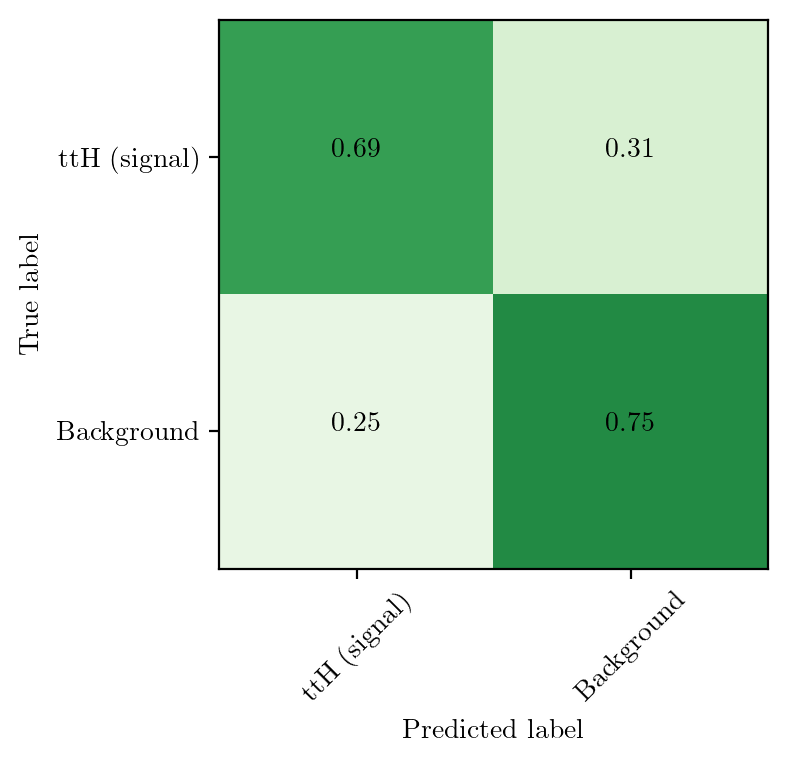

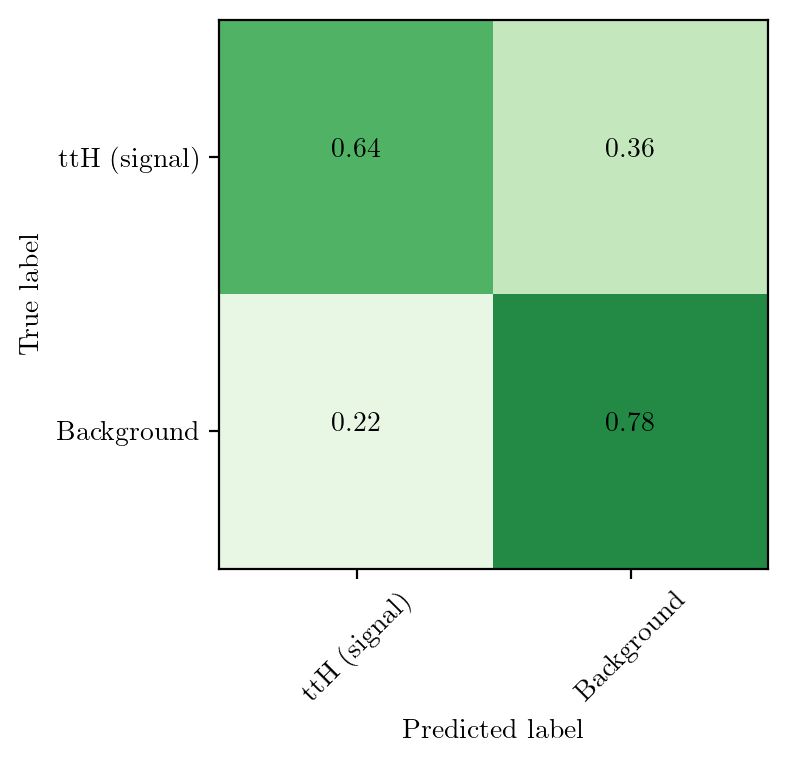

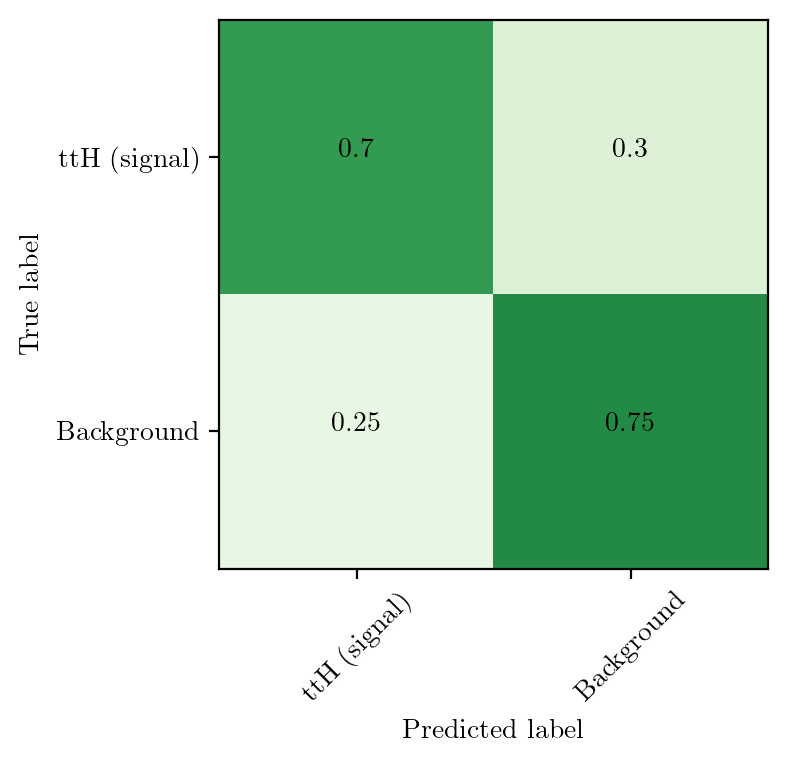

In [9]:
for name, cm in zip(labels, cm_list):
    params_cm = {'title' : (''),
             'x_axis' : 'Predicted label',
             'y_axis' : 'True label',
             'class_names' : class_names,
             'figsize' : (4, 4),
             'dpi' : 200,
             'colourbar' : False}
    Fig = pltlib.confusion_matrix(cm, params_cm)
    Fig.tight_layout()
#     Fig.savefig(DIR + '{}_confusion_matrix.pdf'.format(name))

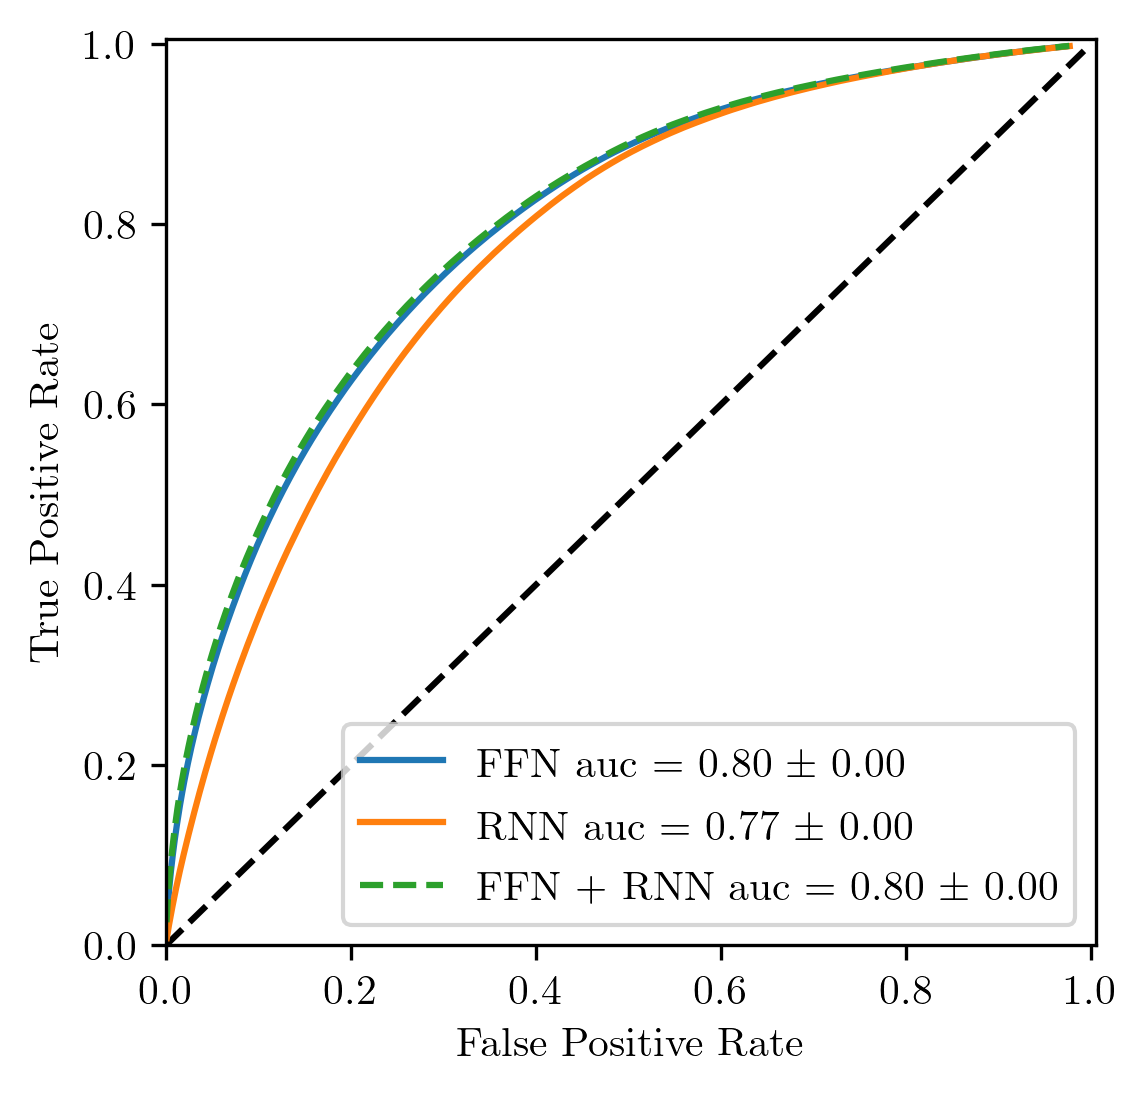

In [10]:
fig4, ax4 = plt.subplots(figsize=(4,4), dpi=300)
ax4.plot([0, 1], [0, 1], 'k--')
    
ax4.set_xlim([0.0, 1.005])
ax4.set_ylim([0.0, 1.005])
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
linestyles = ['-', '-', '--']

for name, df, ls in zip(labels, network_results, linestyles):
    mean_fpr = np.mean(df.roc_fpr_vals, axis=0)
    mean_tpr = np.mean(df.roc_tpr_vals, axis=0)
    
    mean_auc = df.roc_auc.mean()
    std_auc = df.roc_auc.std()
    
    if name == 'FFN' or name=='RNN':
        label = '{} auc = {:.2f} \u00B1 {:.2f}'.format(name, mean_auc, std_auc)
    else:
        label = '{} auc = {:.2f} \u00B1 {:.2f}'.format(name, mean_auc, std_auc)
    
    ax4.plot(mean_fpr, mean_tpr, ls, label=label)

ax4.legend()
#fig4.savefig(DIR + '{0}\\roc_curve_{0}.pdf'.format(RESULTS_DIR))

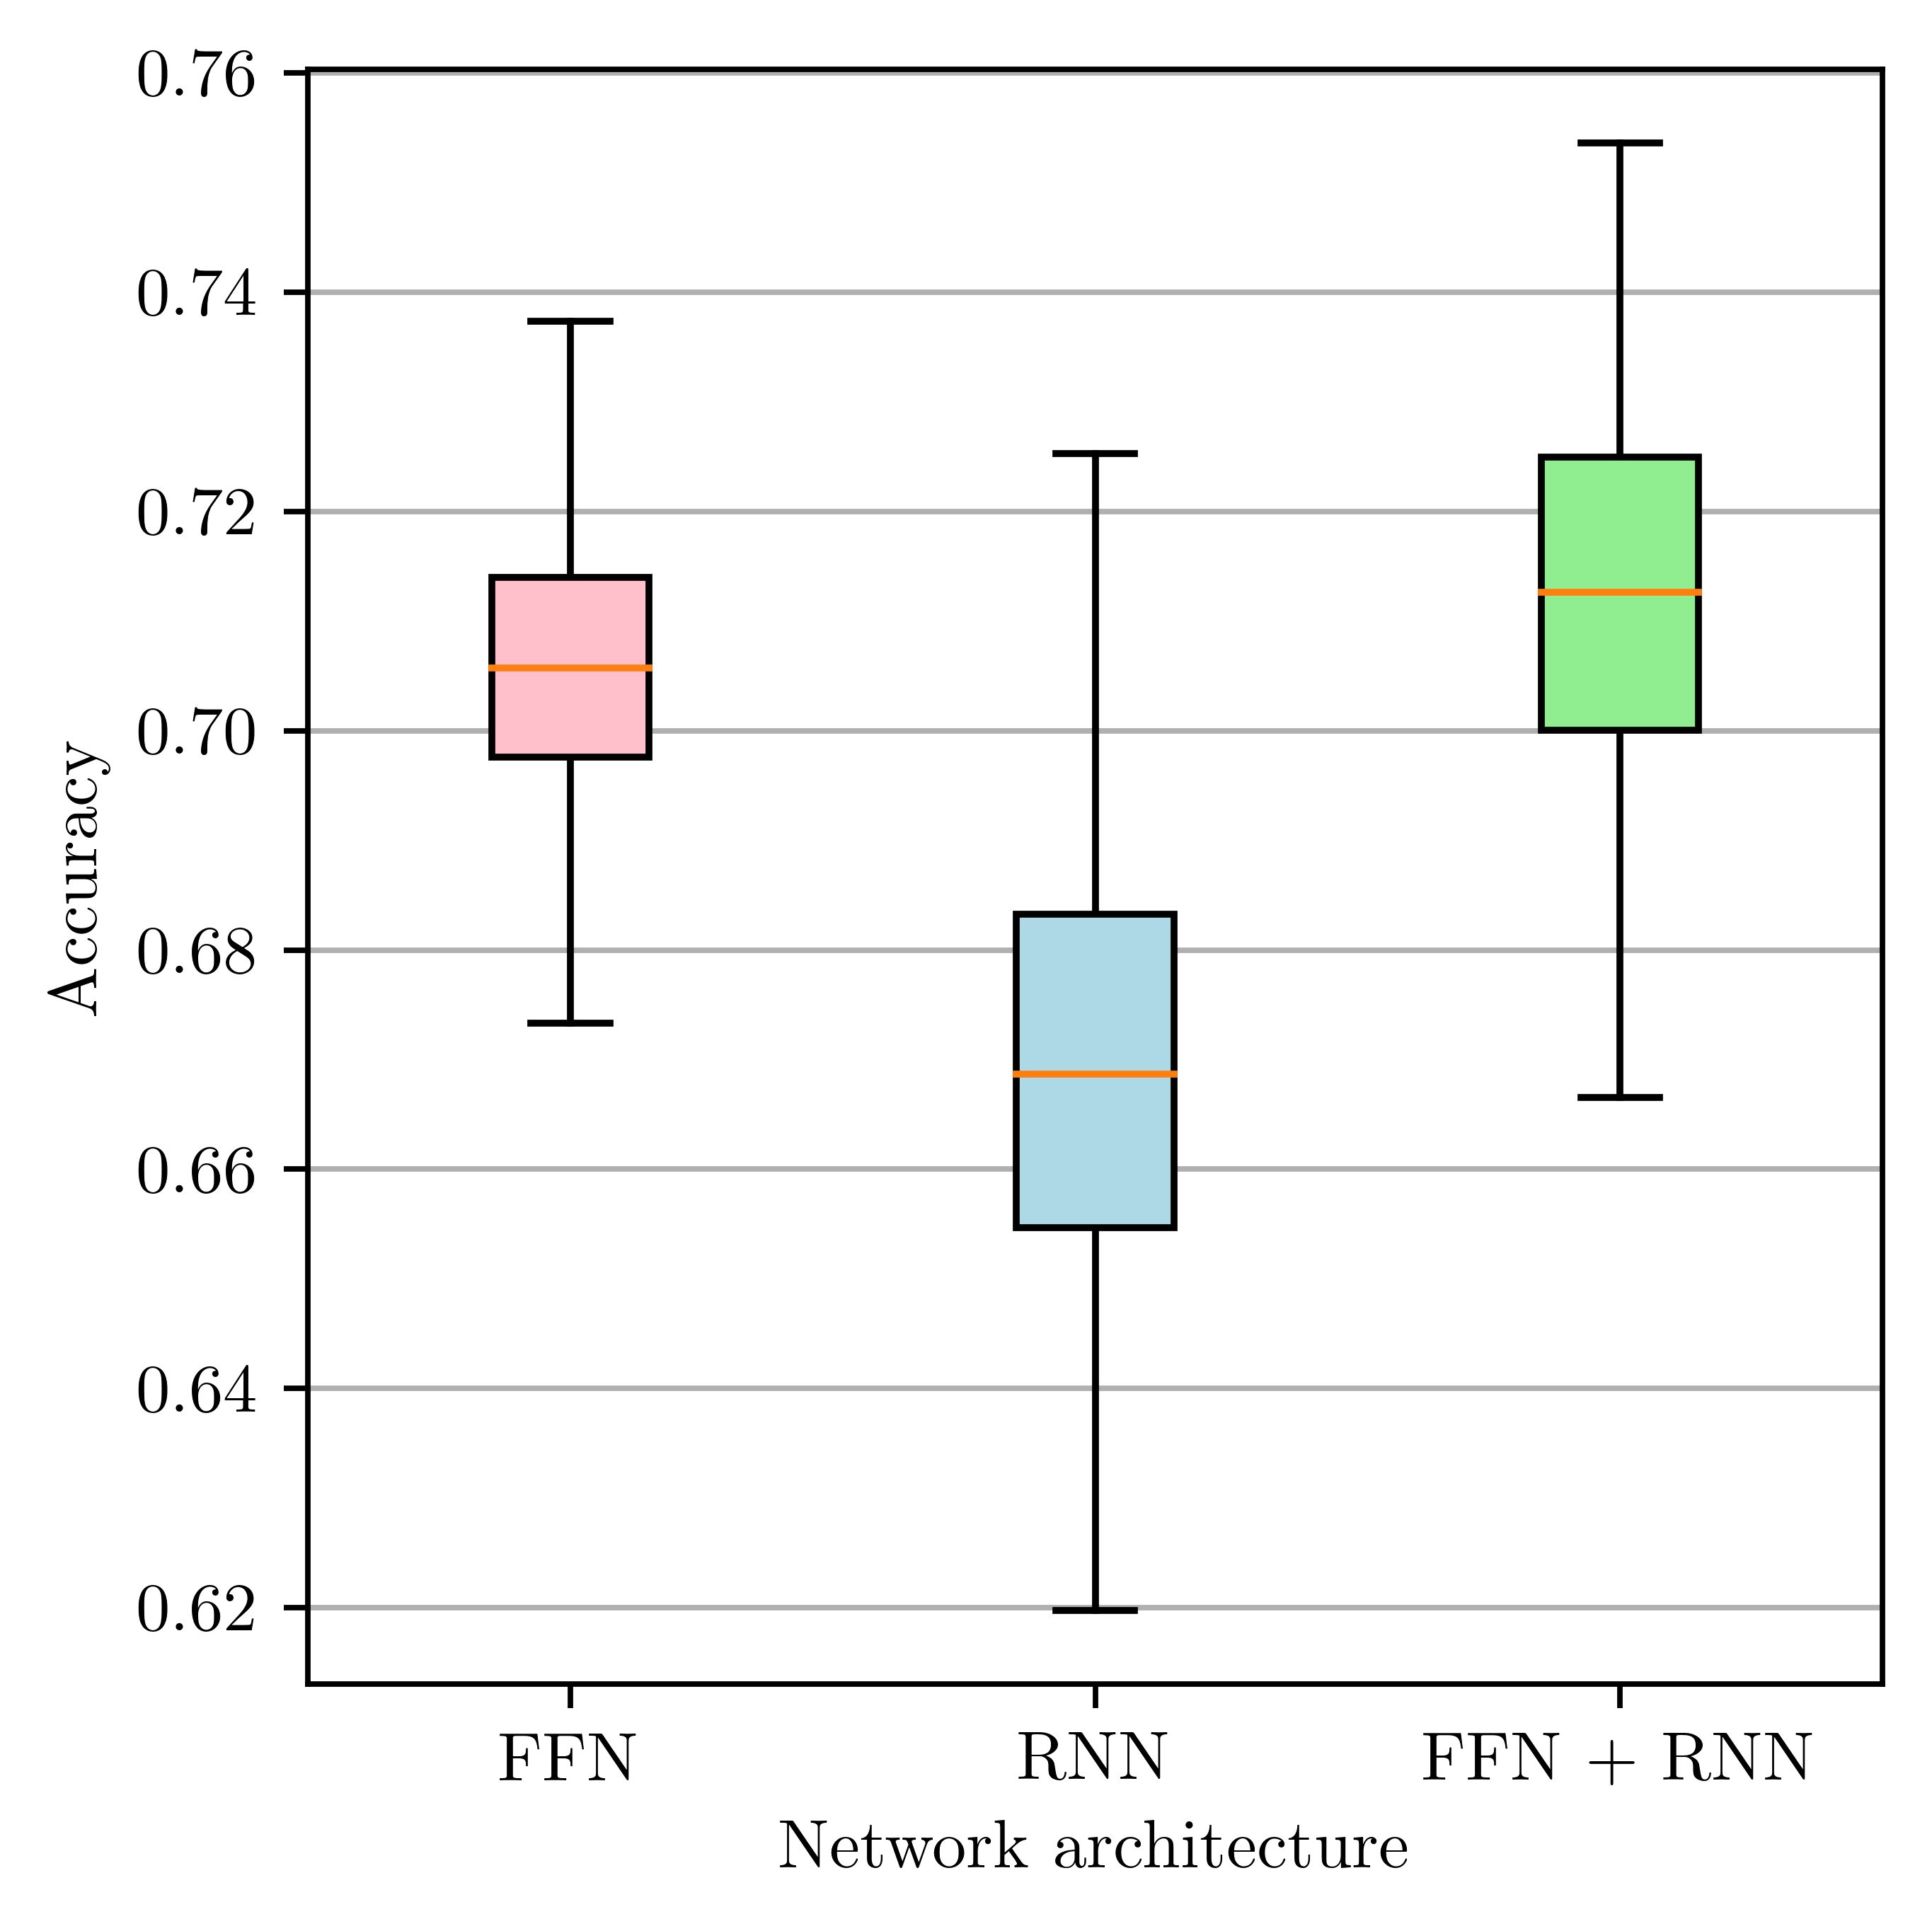

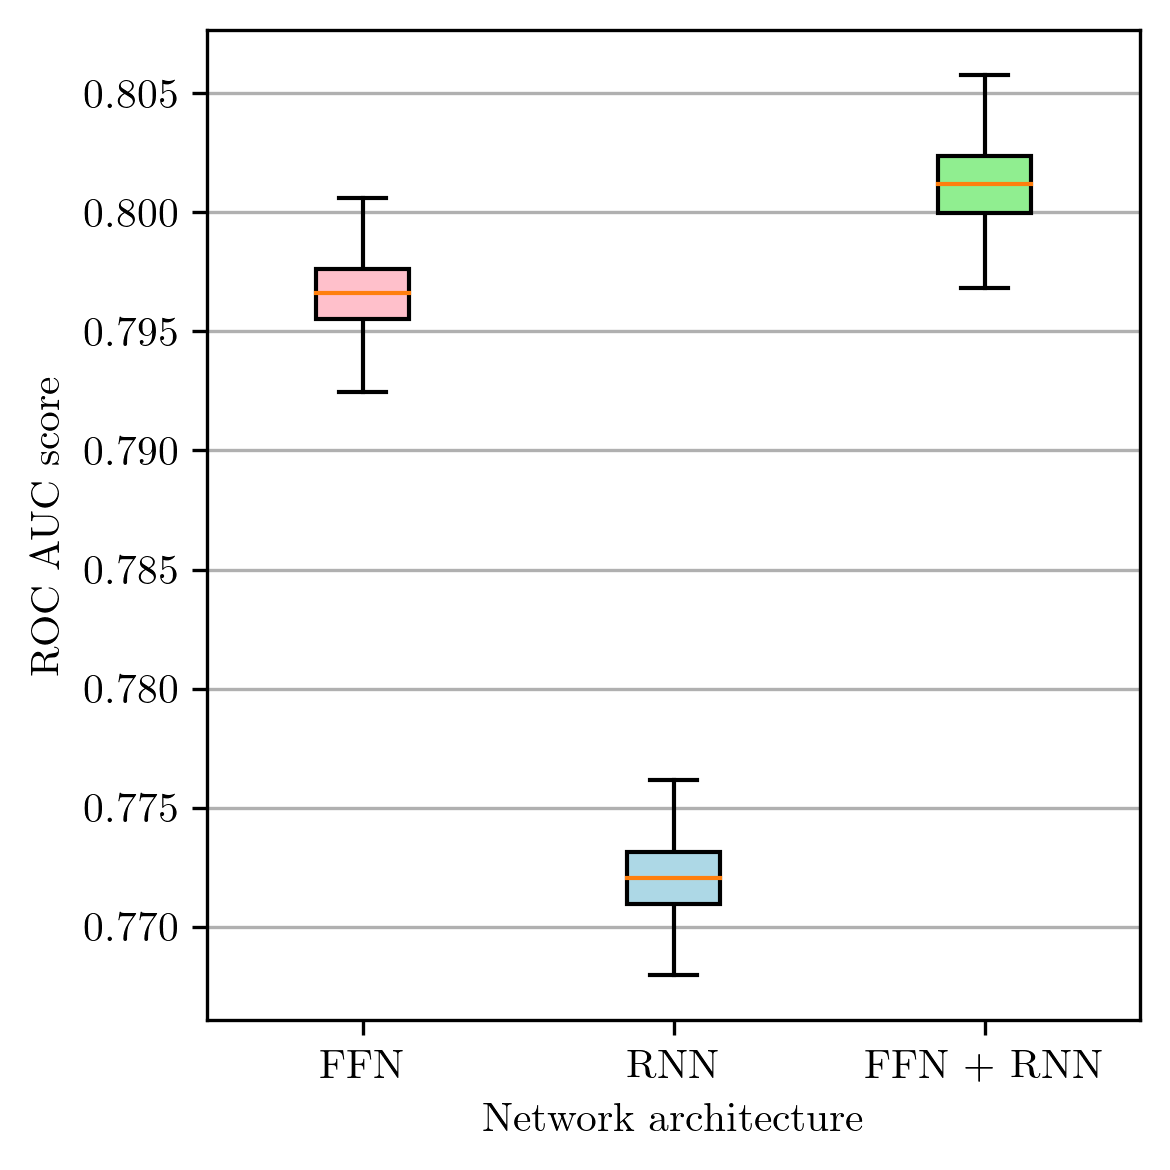

In [11]:
accuracy_results = [df.accuracy_test.to_list() for df in network_results]
roc_auc_results = [df.roc_auc.to_list() for df in network_results]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig5, ax5 = plt.subplots(figsize=(4,4), dpi=700)
ax5.yaxis.grid(True)
boxplot1 = ax5.boxplot(accuracy_results, patch_artist=True, showfliers=False)
ax5.set_xticklabels(labels)
ax5.set_xlabel('Network architecture')
ax5.set_ylabel('Accuracy')

fig6,ax6 = plt.subplots(figsize=(4,4), dpi=300)
ax6.yaxis.grid(True)
boxplot2 = ax6.boxplot(roc_auc_results, patch_artist=True, showfliers=False)
ax6.set_xticklabels(labels)
ax6.set_xlabel('Network architecture')
ax6.set_ylabel('ROC AUC score')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (boxplot1, boxplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
fig5.tight_layout()
fig6.tight_layout()

# fig5.savefig(DIR + 'accuracy_boxplot.pdf')
# fig6.savefig(DIR + 'aoc_boxplot.pdf')

In [12]:
for name, df in zip(labels, network_results):
    mean_accuracy = df.accuracy_test.mean()
    std_accuracy = df.accuracy_test.std()
    
    mean_auc_score = df.roc_auc.mean()
    std_auc_score = df.roc_auc.std()
    
    print('----------Accuracy----------')
    print('{} : {} \u00B1 {}'.format(name, mean_accuracy, std_accuracy))
    print('----------AOC score----------')
    print('{} : {} \u00B1 {}'.format(name, mean_auc_score, std_auc_score))

----------Accuracy----------
FFN : 0.7055417148168674 ± 0.011591610021830375
----------AOC score----------
FFN : 0.7966096197341709 ± 0.0015989010275551292
----------Accuracy----------
RNN : 0.6697406214451103 ± 0.020085013060335354
----------AOC score----------
RNN : 0.7720253209975277 ± 0.0016441559807979275
----------Accuracy----------
FFN + RNN : 0.7128569797339689 ± 0.017336265031172887
----------AOC score----------
FFN + RNN : 0.8011765715025577 ± 0.0018183479698341198


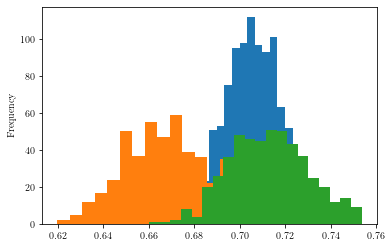

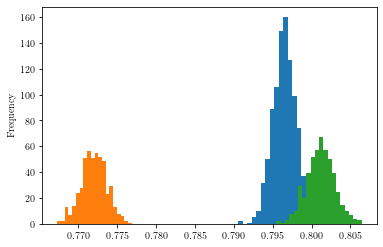

In [13]:
fig7, ax7 = plt.subplots()
fig8, ax8 = plt.subplots()

for df in network_results:
    df['accuracy_test'].plot.hist(bins=20, ax=ax7)
    df['roc_auc'].plot.hist(bins=20, ax=ax8)

    

In [14]:
df_multi = pd.read_pickle('new_multisignal_combined_nn.pkl')
df_multi = df_multi[df_multi.loc[:, 'test_passed'] == True]
df_multi.history_training_data = df_multi.history_training_data.apply(lambda x:np.array(x))
df_multi.history_test_data = df_multi.history_test_data.apply(lambda x:np.array(x))

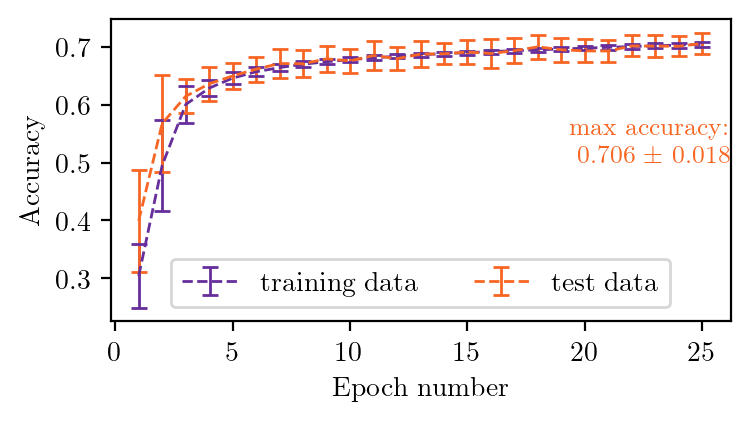

In [15]:
params_history = {'title' : (''),
                'x_axis' : 'Epoch number',
                'y_axis' : 'Accuracy',
                'legend' : ['training data', 'test data'],
                'figsize' : (4, 2),
                'dpi' : 200,
                'colors' : ['#662E9B', '#F86624'],
                'full_y' : False}
    
history_training_data_mean = np.mean(df_multi.history_training_data, axis=0)[:25]
history_test_data_mean = np.mean(df_multi.history_test_data, axis=0)[:25]

history_training_data_std = np.std(df_multi.history_training_data.values, axis=0)[:25]
history_test_data_std = np.std(df_multi.history_test_data.values, axis=0)[:25]

history_error_bars = [history_training_data_std, history_test_data_std]

fig1 = pltlib.training_history_plot(history_training_data_mean,
                          history_test_data_mean,
                          params_history,
                          history_error_bars)

#fig1.savefig(DIR + 'training_curve_multisig.pdf')

In [16]:
df = pd.read_pickle('{0}\\results_FFN_{0}_sig.pkl'.format(RESULTS_DIR))
df = df[df.loc[:, 'test_passed'] == True]

In [17]:
df.columns

Index(['run_index', 'test_train_fraction', 'event_layer_input_shape', 'model',
       'epochs', 'batch_size', 'learning_rate', 'output_shape',
       'layer_2_neurons', 'layer_1_neurons', 'model_architecture',
       'model_type', 'accuracy_test', 'accuracy_test_start',
       'accuracy_training', 'accuracy_training_start', 'background_bin_vals',
       'bin_centres_sig', 'bins', 'boosted_sig', 'cm_accuracy', 'cm_f_score',
       'cm_precision', 'cm_recall', 'confusion_matrix', 'history_test_data',
       'history_training_data', 'max_significance', 'roc_auc', 'roc_fpr_vals',
       'roc_tpr_vals', 'sig_vals', 'signal_bin_vals', 'standard_sig',
       'test_passed', 'time_elapsed', 'time_start'],
      dtype='object')

3.258597684992764 0.038172487178024836
3.386899542769502 0.02869130389164446
0.6567839195979901 0.02795970810943421


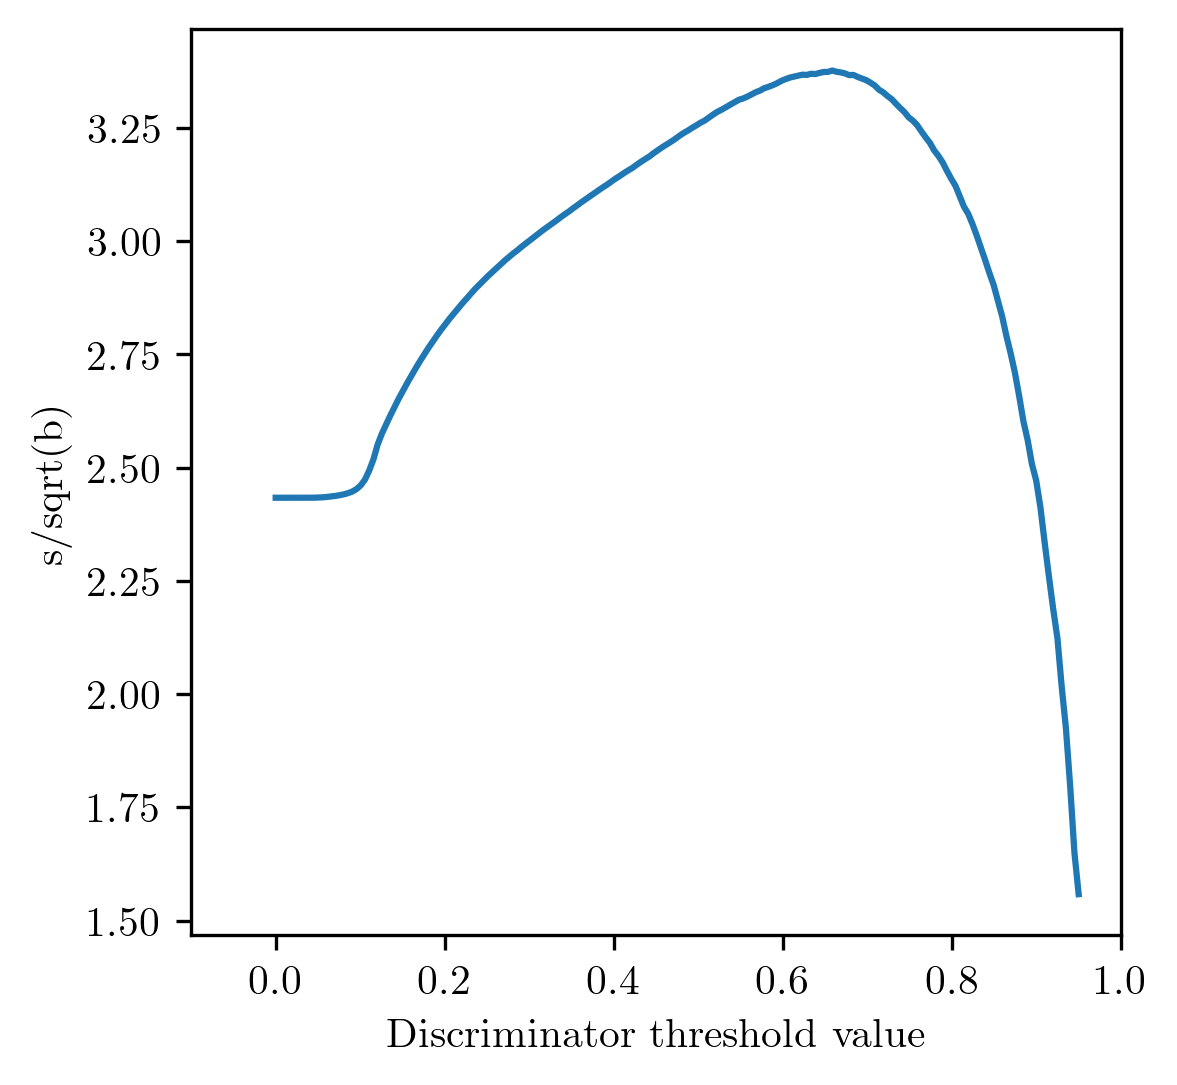

In [22]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)

sig_vals = np.mean(df.sig_vals.apply(lambda x:x[:190]), axis=0)
bin_vals = df.bin_centres_sig.iloc[0][:190]

ax.plot(bin_vals, sig_vals)
ax.set_xlim(-0.1, 1)
ax.set_xlabel('Discriminator threshold value')
ax.set_ylabel('s/sqrt(b)')

fig.savefig(DIR + 'new_sig_plot.pdf')
print(df.standard_sig.mean(), df.standard_sig.std())
print(df.boosted_sig.mean(), df.boosted_sig.std())
print(df.max_significance.mean(),df.max_significance.std())

In [19]:
print(df.sig_vals.apply(lambda x:x.shape))

0    (196,)
1    (193,)
2    (190,)
3    (195,)
0    (193,)
1    (190,)
2    (192,)
3    (194,)
0    (195,)
1    (195,)
2    (194,)
3    (195,)
0    (192,)
1    (195,)
2    (196,)
3    (195,)
0    (194,)
1    (192,)
2    (195,)
3    (195,)
Name: sig_vals, dtype: object
